## **FINANCIAL INSIGHT ENGINE - BUSINESS-FOCUSED EVALUATION**

In [1]:
import os
import json
import logging
import hashlib
import numpy as np
import pandas as pd
from datetime import datetime
from typing import Dict, List, Optional, Tuple, Any
from dataclasses import dataclass, field, asdict
from collections import defaultdict
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from dotenv import load_dotenv
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from src.utils import clean_corpus, refine_corpus
from src.llm_module import analyze_with_semantic_search
from src.scraping_module import UnifiedFinancialScraper
from src.eval import *

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emmanueladeleye/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2026-01-16 14:35:56,264 - INFO - Loading faiss.
2026-01-16 14:35:56,294 - INFO - Successfully loaded faiss.
2026-01-16 14:35:56,298 - INFO - Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes.


#### Use Case 1

In [5]:
query = "US stock market"
scraper = UnifiedFinancialScraper(query=query)
result_df = scraper.fetch_all(include_social=True)
logger.info(f"Scraping complete | Total articles fetched: {len(result_df)}")
logger.info("Commencing cleaning and refining the corpus")
result_df['full_response'] = " Source: " + result_df['source'] + "\n" + result_df['title'] + '\n' + result_df['content']

texts_list = result_df['title'] + '\n' + result_df['content']

# Stack them all into a single string
all_text = "\n".join(texts_list)     
logger.info(f"News pull complete | Total articles fetched: {len(result_df)}")

2026-01-16 01:14:40,376 - INFO - Fetched 0 RSS articles
2026-01-16 01:14:41,095 - INFO - Fetched 98 Google News articles
2026-01-16 01:14:41,696 - INFO - Fetched 0 Finnhub articles
2026-01-16 01:14:42,075 - INFO - Fetched 0 Alpha Vantage articles
2026-01-16 01:14:42,434 - INFO - Fetched 100 NewsAPI articles
2026-01-16 01:14:47,624 - INFO - Fetched 112 Reddit posts
2026-01-16 01:14:47,627 - INFO - Total articles before deduplication: 310
2026-01-16 01:14:47,671 - INFO - Total articles after deduplication: 290
2026-01-16 01:14:47,673 - INFO - Scraping complete | Total articles fetched: 290
2026-01-16 01:14:47,674 - INFO - Commencing cleaning and refining the corpus
2026-01-16 01:14:47,678 - INFO - News pull complete | Total articles fetched: 290


                                                 title   source  quality_score
155  INVESTOR NOTICE: Faruqi & Faruqi, LLP Investig...  NewsAPI           0.75
125  JBDI Holdings Announces Receipt of Notice of D...  NewsAPI           0.75
127  The least sexy ASX stocks for 2026 (Don't even...  NewsAPI           0.75
128  To avoid FATF grey list, Pakistan used lobbyin...  NewsAPI           0.75
129  European Stocks Hover Near Record High as Trad...  NewsAPI           0.75
130  Interactive Brokers says betting on US midterm...  NewsAPI           0.75
131  U.S. big banks' profit parade at risk after Tr...  NewsAPI           0.75
132  Wall Street Profit Parade at Risk After Trump’...  NewsAPI           0.75
133  Indian Oil targets 20-30% revenue from non-fue...  NewsAPI           0.75
134                           metaai-sdk added to PyPI  NewsAPI           0.75
source
NewsAPI                      99
Reddit r/stocks              30
Reddit r/investing           29
Reddit r/fatFIRE            

In [10]:
cleaned_corpus = refine_corpus(all_text)
logger.info(
    "Corpus refined | original=%d | cleaned=%d",
    len(all_text),
    len(cleaned_corpus)
)

2026-01-16 01:15:27,589 - INFO - Corpus refined | original=235133 | cleaned=1159


In [11]:
results, context_dets = analyze_with_semantic_search(query, cleaned_corpus)

/Users/emmanueladeleye/Documents/DS Projects/Financial Insights Generator/Modular-Real-Time-Financial-News/src/llm_module.py:93: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(openai_api_key=openai_api)
2026-01-16 01:18:02,828 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
/Users/emmanueladeleye/Documents/DS Projects/Financial Insights Generator/Modular-Real-Time-Financial-News/src/llm_module.py:109: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  relevant_text = ensemble_retriever.get_

In [17]:
context = [doc.page_content for doc in context_dets if len(doc.page_content.strip()) > 1]

In [14]:
results

{'key_insights': '1. US stocks performed well in 2025, especially large caps and tech sectors. 2. International markets outpaced US markets in terms of returns. 3. Growing interest in tokenized stocks as an alternative way to access equities. 4. Global markets outside the US led in performance last year. 5. US stock market ended 2025 on a high note after a volatile year.',
 'key_drivers': "The Fed's rate cuts, international market performance, growing interest in tokenized stocks, and a weaker US dollar were key drivers in the US stock market.",
 'risks': 'Potential risks include uncertainties around future unemployment trends, market volatility, and geopolitical factors impacting global markets.',
 'sentiment': 'Overall sentiment is positive as US stocks performed well and ended on a high note in 2025. However, there is a neutral sentiment regarding the future outlook due to uncertainties in the economy and global markets. Sentiment degree is 60% positive, 40% neutral.'}

In [18]:
context

["average low. As of today's 1217 price action, it looks like the market is pricing in the possibility of an accelerating unemployment trend that could continue in January's print. The Fed recently cut rates which may help reduce firing rates as cost saving measures, but January's unemployment print will be critical in understanding where the economy is at and likely where the stock market will go next. 2025 recap: US stocks did well, but international markets outpaced them Now that 2025 has wrapped up, its interesting to see how different markets performed, it was really goof for US stocks, especially large caps and tech, though many international markets actually delivered stronger returns overall, In other trading news, tokenized stocks are gaining traction, for example, Bitget recently recorded around 1 B in trading volume for these products, these shows there is growing interest in alternative ways to access equities. Looking closer, the MSCI All Country World exUSA index, which",

In [19]:
print("=" * 60)
print("Financial Insight Evaluator - Demo")
print("=" * 60)

evaluator = FinancialInsightEvaluator()
report = evaluator.evaluate(
    query=query,
    output=results,
    source_chunks=context
)

print("\n" + evaluator.generate_report_markdown(report))

2026-01-16 01:22:46,936 - INFO - Loading embedding model: all-MiniLM-L6-v2
2026-01-16 01:22:47,024 - INFO - Use pytorch device_name: mps
2026-01-16 01:22:47,024 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Financial Insight Evaluator - Demo


2026-01-16 01:22:49,838 - INFO - FinancialInsightEvaluator initialized successfully
2026-01-16 01:22:49,842 - INFO - ============================================================
2026-01-16 01:22:49,846 - INFO - Starting comprehensive evaluation
2026-01-16 01:22:49,846 - INFO - ============================================================
2026-01-16 01:22:49,847 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 01:22:52,175 - INFO - Faithfulness: 8/10 claims supported (score: 0.800)
2026-01-16 01:22:52,176 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 01:22:54,812 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 01:22:54,846 - INFO - Relevance: 5.0/5 (semantic sim: 0.637)
2026-01-16 01:22:54,847 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 01:22:58,114 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 01:22:58,131 - INFO - Coherence: 4.0/5 (internal: 0.417)
2026-01-16 01:22:58,131 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 01:22:58,386 - INFO - Coverage: 10/20 terms (score: 0.607)
2026-01-16 01:22:58,386 - INFO - Evaluating specificity...
2026-01-16 01:22:58,388 - INFO - Specificity: 9 entities, 10 numerics, 1 vague phrases
2026-01-16 01:22:58,388 - INFO - Evaluating sentiment calibration...
2026-01-16 01:22:59,406 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 01:22:59,420 - INFO - Sentiment calibration: stated=positive, detected=positive
2026-01-16 01:22:59,422 - INFO - ============================================================
2026-01-16 01:22:59,423 - INFO - Evaluation complete. Aggregate score: 0.814
2026-01-16 01:22:59,423 - INFO - ============================================================



# Financial Insight Evaluation Report

**Query:** US stock market  
**Timestamp:** 2026-01-16T01:22:49.847157  
**Aggregate Score:** 81.36%

---

## Summary Metrics

| Metric | Score | Details |
|--------|-------|---------|
| Faithfulness | 80.00% | 8/10 claims supported |
| Relevance | 100.00% | Raw: 5.0/5, Semantic: 0.64 |
| Coherence | 61.66% | Internal: 0.42, Logic: 0.75 |
| Coverage | 60.73% | Entity: 0.71, Topic: 0.50 |
| Specificity | 99.31% | 9 entities, 10 numerics |
| Sentiment Calibration | 90.00% | Stated: positive, Detected: positive |

---

## Detailed Analysis

### Faithfulness Analysis
- **Score:** 80.00%
- **Supported Claims:** 8 of 10

### Coverage Analysis  
- **Key Terms Captured:** market, stock, stock market, stocks, markets...
- **Notable Gaps:** nbsp, dow, 500, nasdaq, today...

### Specificity Breakdown
- Named Entities: 9
- Numeric Claims: 10
- Vague Phrases: 1
- Specificity Ratio: 0.90

---

*Generated by FinancialInsightEvaluator v1.0*



#### Use Case 2

In [20]:
query_2 = "Apple Q4 2025 growth"
scraper_2 = UnifiedFinancialScraper(query=query_2)
result_df_2 = scraper.fetch_all(include_social=True)
logger.info(f"Scraping complete | Total articles fetched: {len(result_df_2)}")
logger.info("Commencing cleaning and refining the corpus")
result_df_2['full_response'] = " Source: " + result_df_2['source'] + "\n" + result_df_2['title'] + '\n' + result_df_2['content']

texts_list_2 = result_df_2['title'] + '\n' + result_df_2['content']

# Stack them all into a single string
all_text_2 = "\n".join(texts_list_2)     
logger.info(f"News pull complete | Total articles fetched: {len(result_df_2)}")

2026-01-16 01:35:20,293 - INFO - Fetched 0 RSS articles
2026-01-16 01:35:21,174 - INFO - Fetched 99 Google News articles
2026-01-16 01:35:21,801 - INFO - Fetched 0 Finnhub articles
2026-01-16 01:35:22,278 - INFO - Fetched 0 Alpha Vantage articles
2026-01-16 01:35:22,747 - INFO - Fetched 100 NewsAPI articles
2026-01-16 01:35:27,413 - INFO - Fetched 111 Reddit posts
2026-01-16 01:35:27,424 - INFO - Total articles before deduplication: 310
2026-01-16 01:35:27,463 - INFO - Total articles after deduplication: 290
2026-01-16 01:35:27,465 - INFO - Scraping complete | Total articles fetched: 290
2026-01-16 01:35:27,466 - INFO - Commencing cleaning and refining the corpus
2026-01-16 01:35:27,468 - INFO - News pull complete | Total articles fetched: 290


                                                 title   source  quality_score
155  US Stocks Extend Drop as Data Fails to Convinc...  NewsAPI           0.75
125  Bitcoin price (BTC USD) hits 2-month high afte...  NewsAPI           0.75
127  Bitwise lists Bitcoin, Ether and Solana ETPs o...  NewsAPI           0.75
128  JBDI Holdings Announces Receipt of Notice of D...  NewsAPI           0.75
129  Protests in Kargil against US President, Israe...  NewsAPI           0.75
130  The least sexy ASX stocks for 2026 (Don't even...  NewsAPI           0.75
131  To avoid FATF grey list, Pakistan used lobbyin...  NewsAPI           0.75
132  European Stocks Hover Near Record High as Trad...  NewsAPI           0.75
133  Interactive Brokers says betting on US midterm...  NewsAPI           0.75
134  U.S. big banks' profit parade at risk after Tr...  NewsAPI           0.75
source
NewsAPI                      99
Reddit r/stocks              30
Reddit r/investing           29
Reddit r/fatFIRE            

In [21]:
cleaned_corpus_2 = refine_corpus(all_text_2)
logger.info(
    "Corpus refined | original=%d | cleaned=%d",
    len(all_text_2),
    len(cleaned_corpus_2)
)

2026-01-16 01:35:27,513 - INFO - Corpus refined | original=231627 | cleaned=1144


In [23]:
results_2, context_dets_2 = analyze_with_semantic_search(query_2, cleaned_corpus_2)
context_2 = [doc.page_content for doc in context_dets_2 if len(doc.page_content.strip()) > 1]

2026-01-16 01:35:52,863 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 01:35:54,871 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 01:35:56,552 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [24]:
results_2

{'key_insights': 'Apple Q4 2025 growth is strong with a significant increase in net income and EBITDA, outperforming expectations',
 'key_drivers': 'Positive market sentiment towards tech stocks, particularly Apple, fueled by AI optimism and strong financial performance',
 'risks': "Potential risks include market volatility, regulatory challenges, and global economic uncertainties that could impact Apple's growth trajectory",
 'sentiment': 'Overall sentiment is positive, evidenced by the strong financial results and market outperformance, with a sentiment degree of 80%'}

In [25]:
context_2

['vegan. Less than two years after becoming the first global beauty brand to exclusively stock vegan-certified products, the British company has said that this i Calavo Growers, Inc. Announces Fourth Quarter and Fiscal Year 2025 Financial Results Delivered Full Year 2025 Growth of 191 in Net Income from continuing operations, 42 in Adjusted Net Income from continuing operations and 12 in Adjusted EBITDA from continuing operations Annou Orchid Island Capital Announces Estimated Fourth Quarter 2025 Results and December 31, 2025 RMBS Portfolio Characteristics Estimated Book Value Per Share as of December 31, 2025 of 7.54Estimated GAAP net income of 0.62 per share for the quarter ended December 31, 2025, including an estimated 0.43 per  Antelope Enterprise Holdings Limited Receives NASDAQ Notice Related to Late Filing of Its Interim Report New York, NY, Jan. 14, 2026 GLOBE NEWSWIRE -- Antelope Enterprise Holdings Limited NASDAQ: AEHL, or the Company, today announced that today announced',


In [27]:
print("=" * 60)
print("Financial Insight Evaluator - Demo")
print("=" * 60)

evaluator_2 = FinancialInsightEvaluator()
report_2 = evaluator_2.evaluate(
    query=query_2,
    output=results_2,
    source_chunks=context_2
)

print("\n" + evaluator_2.generate_report_markdown(report_2))

2026-01-16 01:38:26,655 - INFO - Loading embedding model: all-MiniLM-L6-v2
2026-01-16 01:38:26,662 - INFO - Use pytorch device_name: mps
2026-01-16 01:38:26,663 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Financial Insight Evaluator - Demo


2026-01-16 01:38:28,289 - INFO - FinancialInsightEvaluator initialized successfully
2026-01-16 01:38:28,290 - INFO - ============================================================
2026-01-16 01:38:28,290 - INFO - Starting comprehensive evaluation
2026-01-16 01:38:28,290 - INFO - ============================================================
2026-01-16 01:38:28,291 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 01:38:30,355 - INFO - Faithfulness: 2/5 claims supported (score: 0.400)
2026-01-16 01:38:30,357 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 01:38:33,211 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 01:38:33,222 - INFO - Relevance: 5.0/5 (semantic sim: 0.789)
2026-01-16 01:38:33,223 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 01:38:36,059 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 01:38:36,066 - INFO - Coherence: 4.0/5 (internal: 0.333)
2026-01-16 01:38:36,067 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 01:38:36,170 - INFO - Coverage: 5/20 terms (score: 0.324)
2026-01-16 01:38:36,170 - INFO - Evaluating specificity...
2026-01-16 01:38:36,172 - INFO - Specificity: 6 entities, 2 numerics, 3 vague phrases
2026-01-16 01:38:36,172 - INFO - Evaluating sentiment calibration...
2026-01-16 01:38:36,782 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 01:38:36,788 - INFO - Sentiment calibration: stated=positive, detected=positive
2026-01-16 01:38:36,789 - INFO - ============================================================
2026-01-16 01:38:36,789 - INFO - Evaluation complete. Aggregate score: 0.663
2026-01-16 01:38:36,791 - INFO - ============================================================



# Financial Insight Evaluation Report

**Query:** Apple Q4 2025 growth  
**Timestamp:** 2026-01-16T01:38:28.290950  
**Aggregate Score:** 66.29%

---

## Summary Metrics

| Metric | Score | Details |
|--------|-------|---------|
| Faithfulness | 40.00% | 2/5 claims supported |
| Relevance | 100.00% | Raw: 5.0/5, Semantic: 0.79 |
| Coherence | 58.32% | Internal: 0.33, Logic: 0.75 |
| Coverage | 32.41% | Entity: 0.40, Topic: 0.25 |
| Specificity | 95.65% | 6 entities, 2 numerics |
| Sentiment Calibration | 98.00% | Stated: positive, Detected: positive |

---

## Detailed Analysis

### Faithfulness Analysis
- **Score:** 40.00%
- **Supported Claims:** 2 of 5

### Coverage Analysis  
- **Key Terms Captured:** 2025, stocks, income, tech, net...
- **Notable Gaps:** december, year, 31, tesla, new...

### Specificity Breakdown
- Named Entities: 6
- Numeric Claims: 2
- Vague Phrases: 3
- Specificity Ratio: 0.67

---

*Generated by FinancialInsightEvaluator v1.0*



#### **BATCH EVALUATION**

In [2]:
# =============================================================================
# TEST QUERY SUITE
# =============================================================================

TEST_QUERIES = [
    # Market-level queries
    "US stock market outlook",
    "S&P 500 performance",
    "Nasdaq tech stocks",
    
    # Sector-specific
    "Banking sector earnings",
    "Tech sector AI stocks",
    "Energy sector oil prices",
    "Healthcare biotech stocks",
    
    # Macro themes
    "Federal Reserve interest rates",
    "Inflation expectations CPI",
    "China trade policy tariffs",
    
    # Asset classes
    "Treasury bond yields",
    "Gold prices safe haven",
    "Cryptocurrency Bitcoin regulation",
    
    # Company-specific (optional - may have less coverage)
    "Apple earnings growth",
    "Tesla stock analysis",
]

In [3]:
# =============================================================================
# BATCH EVALUATION CLASS
# =============================================================================

@dataclass
class QueryResult:
    """Results for a single query evaluation."""
    query: str
    timestamp: str
    articles_fetched: int
    faithfulness: float
    relevance: float
    coherence: float
    coverage: float
    specificity: float
    sentiment_calibration: float
    aggregate_score: float
    success: bool
    error: Optional[str] = None


class BatchEvaluator:
    """
    Runs evaluation pipeline across multiple queries and aggregates results.
    """
    
    def __init__(
        self,
        output_dir: str = "evaluation_results",
        include_social: bool = False,  # Faster without Reddit
        skip_existing: bool = True
    ):
        self.output_dir = output_dir
        self.include_social = include_social
        self.skip_existing = skip_existing
        
        # Create output directories
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(os.path.join(output_dir, "figures"), exist_ok=True)
        
        # Initialize evaluator once (expensive - loads models)
        logger.info("Initializing evaluator...")
        self.evaluator = FinancialInsightEvaluator()
        
        self.results: List[QueryResult] = []
        
    def run_single_query(self, query: str) -> QueryResult:
        """
        Run full pipeline for a single query.
        
        Pipeline:
        1. Scrape news sources
        2. Clean and refine corpus
        3. Generate insights via RAG
        4. Evaluate output quality
        """
        timestamp = datetime.now().isoformat()
        
        try:
            # Step 1: Scrape
            logger.info(f"[{query}] Scraping news sources...")
            scraper = UnifiedFinancialScraper(query=query)
            result_df = scraper.fetch_all(include_social=self.include_social)
            articles_fetched = len(result_df)
            
            if articles_fetched == 0:
                raise ValueError("No articles fetched")
            
            # Step 2: Prepare corpus
            texts_list = result_df['title'] + '\n' + result_df['content']
            all_text = "\n".join(texts_list)
            cleaned_corpus = refine_corpus(all_text)
            
            # Step 3: Generate insights
            logger.info(f"[{query}] Generating insights...")
            results, context_docs = analyze_with_semantic_search(query, cleaned_corpus)
            context = [doc.page_content for doc in context_docs if len(doc.page_content.strip()) > 1]
            
            # Step 4: Evaluate
            logger.info(f"[{query}] Evaluating output...")
            report = self.evaluator.evaluate(
                query=query,
                output=results,
                source_chunks=context
            )
            
            return QueryResult(
                query=query,
                timestamp=timestamp,
                articles_fetched=articles_fetched,
                faithfulness=report.faithfulness.score,
                relevance=report.relevance.score,
                coherence=report.coherence.score,
                coverage=report.coverage.score,
                specificity=report.specificity.score,
                sentiment_calibration=report.sentiment_calibration.score,
                aggregate_score=report.aggregate_score,
                success=True
            )
            
        except Exception as e:
            logger.error(f"[{query}] Failed: {str(e)}")
            return QueryResult(
                query=query,
                timestamp=timestamp,
                articles_fetched=0,
                faithfulness=0.0,
                relevance=0.0,
                coherence=0.0,
                coverage=0.0,
                specificity=0.0,
                sentiment_calibration=0.0,
                aggregate_score=0.0,
                success=False,
                error=str(e)
            )
    
    def run_batch(self, queries: List[str] = None) -> pd.DataFrame:
        """
        Run evaluation on all queries.
        
        Args:
            queries: List of queries (defaults to TEST_QUERIES)
            
        Returns:
            DataFrame with all results
        """
        queries = queries or TEST_QUERIES
        
        logger.info(f"Starting batch evaluation on {len(queries)} queries")
        logger.info("=" * 60)
        
        for i, query in enumerate(tqdm(queries, desc="Evaluating queries")):
            logger.info(f"\n[{i+1}/{len(queries)}] Processing: {query}")
            result = self.run_single_query(query)
            self.results.append(result)
            
            # Save intermediate results (in case of crash)
            self._save_intermediate()
        
        logger.info("=" * 60)
        logger.info("Batch evaluation complete!")
        
        return self.get_results_df()
    
    def _save_intermediate(self):
        """Save results after each query (crash protection)."""
        results_path = os.path.join(self.output_dir, "batch_results_intermediate.json")
        with open(results_path, 'w') as f:
            json.dump([asdict(r) for r in self.results], f, indent=2)
    
    def get_results_df(self) -> pd.DataFrame:
        """Convert results to DataFrame."""
        return pd.DataFrame([asdict(r) for r in self.results])
    
    def compute_aggregate_statistics(self) -> Dict[str, Dict[str, float]]:
        """
        Compute mean ± std for all metrics across successful runs.
        
        Returns:
            Dictionary with statistics for each metric
        """
        df = self.get_results_df()
        successful = df[df['success'] == True]
        
        if len(successful) == 0:
            logger.warning("No successful evaluations!")
            return {}
        
        metrics = [
            'faithfulness', 'relevance', 'coherence', 
            'coverage', 'specificity', 'sentiment_calibration', 
            'aggregate_score'
        ]
        
        stats = {}
        for metric in metrics:
            values = successful[metric].values
            stats[metric] = {
                'mean': float(np.mean(values)),
                'std': float(np.std(values)),
                'min': float(np.min(values)),
                'max': float(np.max(values)),
                'median': float(np.median(values)),
                'n': len(values)
            }
        
        return stats
    def save_all_results(self):
        """Save all results and generate outputs."""
        
        # 1. Raw results JSON
        results_path = os.path.join(self.output_dir, "batch_results.json")
        with open(results_path, 'w') as f:
            json.dump([asdict(r) for r in self.results], f, indent=2)
        logger.info(f"Saved raw results: {results_path}")
        
        # 2. Summary CSV
        df = self.get_results_df()
        csv_path = os.path.join(self.output_dir, "batch_summary.csv")
        df.to_csv(csv_path, index=False)
        logger.info(f"Saved summary CSV: {csv_path}")
        
        # 3. Aggregate statistics
        stats = self.compute_aggregate_statistics()
        stats_path = os.path.join(self.output_dir, "aggregate_statistics.json")
        with open(stats_path, 'w') as f:
            json.dump(stats, f, indent=2)
        logger.info(f"Saved aggregate stats: {stats_path}")

        # 4. Generate visualizations
        self.generate_visualizations()
        
        return {
            'results_json': results_path,
            'summary_csv': csv_path,
            'statistics': stats_path
        }
    def generate_visualizations(self):
        """Generate publication-quality visualizations."""
        
        df = self.get_results_df()
        successful = df[df['success'] == True]
        
        if len(successful) == 0:
            logger.warning("No successful results to visualize")
            return
        
        # Set style
        plt.style.use('seaborn-v0_8-whitegrid')
        sns.set_palette("husl")
        
        fig_dir = os.path.join(self.output_dir, "figures")
        
        # =================================================================
        # Figure 1: Radar Chart - Average Metrics
        # =================================================================
        metrics = ['faithfulness', 'relevance', 'coherence', 
                   'coverage', 'specificity', 'sentiment_calibration']
        
        values = [successful[m].mean() for m in metrics]
        values += values[:1]  # Close the polygon
        
        angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
        angles += angles[:1]
        
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        ax.fill(angles, values, alpha=0.25, color='steelblue')
        ax.plot(angles, values, 'o-', linewidth=2, color='steelblue')
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels([m.replace('_', '\n').title() for m in metrics], size=10)
        ax.set_ylim(0, 1)
        ax.set_title('Financial Insight Generator\nEvaluation Metrics (n={})'.format(len(successful)), 
                     size=14, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.savefig(os.path.join(fig_dir, 'radar_metrics.png'), dpi=150, bbox_inches='tight')
        plt.close()
        logger.info("Saved radar chart")
        
        # =================================================================
        # Figure 2: Box Plot - Metric Distribution
        # =================================================================
        fig, ax = plt.subplots(figsize=(12, 6))
        
        plot_data = successful[metrics].melt(var_name='Metric', value_name='Score')
        plot_data['Metric'] = plot_data['Metric'].str.replace('_', ' ').str.title()
        
        sns.boxplot(data=plot_data, x='Metric', y='Score', ax=ax, palette='husl')
        sns.stripplot(data=plot_data, x='Metric', y='Score', ax=ax, 
                      color='black', alpha=0.5, size=4)
        
        ax.set_ylim(0, 1.05)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_xlabel('')
        ax.set_title('Evaluation Metric Distribution Across {} Queries'.format(len(successful)),
                     fontsize=14, fontweight='bold')
        ax.tick_params(axis='x', rotation=15)
        
        # Add mean line
        for i, metric in enumerate(metrics):
            mean_val = successful[metric].mean()
            ax.hlines(mean_val, i-0.4, i+0.4, colors='red', linestyles='dashed', linewidth=2)
        
        plt.tight_layout()
        plt.savefig(os.path.join(fig_dir, 'boxplot_distribution.png'), dpi=150, bbox_inches='tight')
        plt.close()
        logger.info("Saved box plot")
        
        # =================================================================
        # Figure 3: Heatmap - Query x Metric Performance
        # =================================================================
        if len(successful) >= 3:
            fig, ax = plt.subplots(figsize=(14, max(8, len(successful)*0.5)))
            
            heatmap_data = successful.set_index('query')[metrics]
            heatmap_data.columns = [c.replace('_', ' ').title() for c in heatmap_data.columns]
            
            sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn',
                        vmin=0, vmax=1, ax=ax, linewidths=0.5,
                        cbar_kws={'label': 'Score'})
            
            ax.set_title('Per-Query Evaluation Results', fontsize=14, fontweight='bold')
            ax.set_ylabel('')
            
            plt.tight_layout()
            plt.savefig(os.path.join(fig_dir, 'heatmap_queries.png'), dpi=150, bbox_inches='tight')
            plt.close()
            logger.info("Saved heatmap")
        
        # =================================================================
        # Figure 4: Aggregate Score Distribution
        # =================================================================
        fig, ax = plt.subplots(figsize=(10, 6))
        
        sns.histplot(successful['aggregate_score'], kde=True, ax=ax, color='steelblue', bins=10)
        
        mean_score = successful['aggregate_score'].mean()
        std_score = successful['aggregate_score'].std()
        
        ax.axvline(mean_score, color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {mean_score:.2%}')
        ax.axvspan(mean_score - std_score, mean_score + std_score, 
                   alpha=0.2, color='red', label=f'±1 Std: {std_score:.2%}')
        
        ax.set_xlabel('Aggregate Score', fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        ax.set_title('Distribution of Aggregate Quality Scores', fontsize=14, fontweight='bold')
        ax.legend(loc='upper left')
        ax.set_xlim(0, 1)
        
        plt.tight_layout()
        plt.savefig(os.path.join(fig_dir, 'aggregate_distribution.png'), dpi=150, bbox_inches='tight')
        plt.close()
        logger.info("Saved aggregate distribution")
        
        # =================================================================
        # Figure 5: Bar Chart with Error Bars (Best for Resume/Presentation)
        # =================================================================
        fig, ax = plt.subplots(figsize=(10, 6))
        
        stats = self.compute_aggregate_statistics()
        means = [stats[m]['mean'] for m in metrics]
        stds = [stats[m]['std'] for m in metrics]
        labels = [m.replace('_', '\n').title() for m in metrics]
        
        x = np.arange(len(metrics))
        bars = ax.bar(x, means, yerr=stds, capsize=5, color='steelblue', 
                      edgecolor='navy', linewidth=1.5, alpha=0.8)
        
        # Add value labels on bars
        for bar, mean, std in zip(bars, means, stds):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                    f'{mean:.0%}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=10)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_ylim(0, 1.15)
        ax.set_title(f'Financial Insight Generator Evaluation\n(Mean ± Std across {len(successful)} queries)',
                     fontsize=14, fontweight='bold')
        
        # Add horizontal reference lines
        ax.axhline(0.8, color='green', linestyle=':', alpha=0.5, label='Strong (≥80%)')
        ax.axhline(0.6, color='orange', linestyle=':', alpha=0.5, label='Moderate (≥60%)')
        ax.legend(loc='lower right')
        
        plt.tight_layout()
        plt.savefig(os.path.join(fig_dir, 'bar_chart_summary.png'), dpi=150, bbox_inches='tight')
        plt.close()
        logger.info("Saved bar chart summary")
        
        logger.info(f"All visualizations saved to {fig_dir}/")

In [4]:
def display_evaluation_dashboard(batch_eval, figsize=(18, 14)):
    """
    Display all evaluation visualizations in a single grid layout.
    
    Call this AFTER batch_eval.save_all_results() to show charts inline.
    
    Args:
        batch_eval: BatchEvaluator instance with results
        figsize: Overall figure size (width, height)
    """
    
    df = batch_eval.get_results_df()
    successful = df[df['success'] == True]
    
    if len(successful) == 0:
        print("No successful results to visualize")
        return
    
    metrics = ['faithfulness', 'relevance', 'coherence', 
               'coverage', 'specificity', 'sentiment_calibration']
    stats = batch_eval.compute_aggregate_statistics()
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
    
    # Create figure with grid layout
    fig = plt.figure(figsize=figsize)
    
    # Define grid: 3 rows, 2 columns
    # Row 1: Radar (left), Bar Chart (right)
    # Row 2: Box Plot (spans full width)
    # Row 3: Heatmap (spans full width)
    
    gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 1.4, 1.3], hspace=0.35, wspace=0.25)
    
    # =========================================================================
    # Plot 1: Radar Chart (Top Left)
    # =========================================================================
    ax1 = fig.add_subplot(gs[0, 0], polar=True)
    
    values = [successful[m].mean() for m in metrics]
    values += values[:1]  # Close polygon
    
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]
    
    ax1.fill(angles, values, alpha=0.25, color='steelblue')
    ax1.plot(angles, values, 'o-', linewidth=2, color='steelblue')
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels([m.replace('_', '\n').title() for m in metrics], size=9)
    ax1.set_ylim(0, 1)
    ax1.set_title('Metric Balance', size=12, fontweight='bold', pad=15)
    
    # =========================================================================
    # Plot 2: Bar Chart with Error Bars (Top Right)
    # =========================================================================
    ax2 = fig.add_subplot(gs[0, 1])
    
    means = [stats[m]['mean'] for m in metrics]
    stds = [stats[m]['std'] for m in metrics]
    labels = [m.replace('_', '\n').title() for m in metrics]
    
    x = np.arange(len(metrics))
    bars = ax2.bar(x, means, yerr=stds, capsize=4, color='steelblue', 
                   edgecolor='navy', linewidth=1.5, alpha=0.8)
    
    # Add value labels
    for bar, mean, std in zip(bars, means, stds):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                 f'{mean:.0%}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, fontsize=9)
    ax2.set_ylabel('Score', fontsize=10)
    ax2.set_ylim(0, 1.15)
    ax2.set_title(f'Mean ± Std (n={len(successful)})', size=12, fontweight='bold')
    ax2.axhline(0.8, color='green', linestyle=':', alpha=0.5)
    ax2.axhline(0.6, color='orange', linestyle=':', alpha=0.5)
    
    # =========================================================================
    # Plot 3: Box Plot (Middle Row - Full Width)
    # =========================================================================
    ax3 = fig.add_subplot(gs[1, :])
    
    plot_data = successful[metrics].melt(var_name='Metric', value_name='Score')
    plot_data['Metric'] = plot_data['Metric'].str.replace('_', ' ').str.title()
    
    sns.boxplot(data=plot_data, x='Metric', y='Score', ax=ax3, palette='husl')
    sns.stripplot(data=plot_data, x='Metric', y='Score', ax=ax3, 
                  color='black', alpha=0.5, size=5)
    
    ax3.set_ylim(0, 1.05)
    ax3.set_ylabel('Score', fontsize=10)
    ax3.set_xlabel('')
    ax3.set_title('Score Distribution by Metric', fontsize=12, fontweight='bold')
    ax3.tick_params(axis='x', rotation=0)
    
    # Add mean markers
    for i, metric in enumerate(metrics):
        mean_val = successful[metric].mean()
        ax3.hlines(mean_val, i-0.4, i+0.4, colors='red', linestyles='dashed', linewidth=2)
    
    # =========================================================================
    # Plot 4: Heatmap (Bottom Row - Full Width)
    # =========================================================================
    ax4 = fig.add_subplot(gs[2, :])
    
    heatmap_data = successful.set_index('query')[metrics]
    heatmap_data.columns = [c.replace('_', ' ').title() for c in heatmap_data.columns]
    
    sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn',
                vmin=0, vmax=1, ax=ax4, linewidths=0.5,
                cbar_kws={'label': 'Score', 'shrink': 0.8})
    
    ax4.set_title('Per-Query Performance Breakdown', fontsize=12, fontweight='bold')
    ax4.set_ylabel('')
    ax4.tick_params(axis='y', rotation=0, labelsize=9)
    
    # =========================================================================
    # Main Title
    # =========================================================================
    fig.suptitle('Financial Insight Generator - Evaluation Dashboard', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # Print Summary Statistics
    # =========================================================================
    print("\n" + "=" * 70)
    print("AGGREGATE STATISTICS")
    print("=" * 70)
    
    summary_df = pd.DataFrame({
        'Metric': [m.replace('_', ' ').title() for m in metrics + ['aggregate_score']],
        'Mean': [f"{stats[m]['mean']:.1%}" for m in metrics + ['aggregate_score']],
        'Std': [f"{stats[m]['std']:.1%}" for m in metrics + ['aggregate_score']],
        'Min': [f"{stats[m]['min']:.1%}" for m in metrics + ['aggregate_score']],
        'Max': [f"{stats[m]['max']:.1%}" for m in metrics + ['aggregate_score']],
    })
    
    print(summary_df.to_string(index=False))
    print("=" * 70)

#### **A/B Testing**

**-- Without reddit scrapping**

In [5]:
print("=" * 60)
print("Financial Insight Generator - Batch Evaluation (Without Reddit Scrapping)")
print("=" * 60)

# Initialize batch evaluator
batch_eval = BatchEvaluator(
    output_dir="evaluation_results",
    include_social=False  # Faster without Reddit scraping
)

# Run evaluation on all test queries
results_df = batch_eval.run_batch(TEST_QUERIES)

# Save all outputs
output_paths = batch_eval.save_all_results()

print("\n" + "=" * 60)
print("EVALUATION COMPLETE")
print("=" * 60)
print(f"\nOutputs saved to:")
for name, path in output_paths.items():
    print(f"  • {name}: {path}")

2026-01-16 14:36:11,415 - INFO - Initializing evaluator...
2026-01-16 14:36:11,448 - INFO - Loading embedding model: all-MiniLM-L6-v2
2026-01-16 14:36:11,490 - INFO - Use pytorch device_name: mps
2026-01-16 14:36:11,490 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Financial Insight Generator - Batch Evaluation (Without Reddit Scrapping)


2026-01-16 14:36:30,114 - INFO - FinancialInsightEvaluator initialized successfully
2026-01-16 14:36:30,141 - INFO - Starting batch evaluation on 15 queries
2026-01-16 14:36:30,146 - INFO - ============================================================
Evaluating queries:   0%|          | 0/15 [00:00<?, ?it/s]2026-01-16 14:36:30,150 - INFO - 
[1/15] Processing: US stock market outlook
2026-01-16 14:36:30,150 - INFO - [US stock market outlook] Scraping news sources...
2026-01-16 14:36:40,544 - INFO - Fetched 0 RSS articles
2026-01-16 14:36:41,189 - INFO - Fetched 98 Google News articles
2026-01-16 14:36:41,850 - INFO - Fetched 0 Finnhub articles
2026-01-16 14:36:42,260 - INFO - Fetched 0 Alpha Vantage articles
2026-01-16 14:36:42,657 - INFO - Fetched 96 NewsAPI articles
2026-01-16 14:36:42,665 - INFO - Total articles before deduplication: 194
2026-01-16 14:36:42,683 - INFO - Total articles after deduplication: 185
2026-01-16 14:36:42,689 - INFO - [US stock market outlook] Generating insig

                                                 title   source  quality_score
193  KUSTOM ENTERTAINMENT, INC. COMPLETES THE DIVES...  NewsAPI           0.75
145  Stock market today: Dow, S&P 500, Nasdaq futur...  NewsAPI           0.75
123  Bernstein Raises EQT Corporation (EQT) PT to $...  NewsAPI           0.75
124  DexCom (DXCM) Releases Preliminary, Unaudited ...  NewsAPI           0.75
125  SKYX Announces $4 Million Strategic Investment...  NewsAPI           0.75
126  US stock market crashes again today – Why Dow,...  NewsAPI           0.75
127  Here’s What Supports Mondelez International’s ...  NewsAPI           0.75
128  BofA CEO Brian Moynihan ‘bullish’ on US econom...  NewsAPI           0.75
129       Earnings roundup: Infosys, Licious and Groww  NewsAPI           0.75
130  Ned Davis Distills Political Angst Into ‘Big M...  NewsAPI           0.75
source
NewsAPI                      91
Yahoo Finance                11
Morningstar Canada            9
CNBC                        

2026-01-16 14:36:43,576 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
/Users/emmanueladeleye/Documents/DS Projects/Financial Insights Generator/Modular-Real-Time-Financial-News/src/llm_module.py:116: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  relevant_text = ensemble_retriever.get_relevant_documents(s_query)
2026-01-16 14:36:44,352 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
/Users/emmanueladeleye/Documents/DS Projects/Financial Insights Generator/Modular-Real-Time-Financial-News/src/llm_module.py:76: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` an

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:36:47,754 - INFO - Faithfulness: 7/11 claims supported (score: 0.636)
2026-01-16 14:36:47,754 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:36:50,791 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:36:50,800 - INFO - Relevance: 5.0/5 (semantic sim: 0.437)
2026-01-16 14:36:50,801 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:36:56,199 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:36:56,203 - INFO - Coherence: 4.0/5 (internal: 0.268)
2026-01-16 14:36:56,204 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:36:56,400 - INFO - Coverage: 14/20 terms (score: 0.699)
2026-01-16 14:36:56,401 - INFO - Evaluating specificity...
2026-01-16 14:36:56,404 - INFO - Specificity: 16 entities, 10 numerics, 0 vague phrases
2026-01-16 14:36:56,404 - INFO - Evaluating sentiment calibration...
2026-01-16 14:36:57,247 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:36:57,250 - INFO - Sentiment calibration: stated=positive, detected=positive
2026-01-16 14:36:57,251 - INFO - ============================================================
2026-01-16 14:36:57,252 - INFO - Evaluation complete. Aggregate score: 0.785
2026-01-16 14:36:57,253 - INFO - ============================================================
Evaluating queries:   7%|▋         | 1/15 [00:27<06:19, 27.11s/it]2026-01-16 14:36:57,259 - INFO - 
[2/15] Processing: S&P 500 performance
2026-01-16 14:36:57,259 - INFO - [S&P 500 performance] Scraping news sources...
2026-01-16 14:37:05,870 - 

                                                 title   source  quality_score
197  The Math Behind Artificial Intelligence: A Gui...  NewsAPI           0.75
124  BAC stock today falls despite Bank of America ...  NewsAPI           0.75
126  Ventas' Quarterly Earnings Preview: What You N...  NewsAPI           0.75
127  Trump Just Juiced the Bull Case for Lockheed M...  NewsAPI           0.75
128  Looking to ‘Sell America’ Amid Fed Drama? Here...  NewsAPI           0.75
129  Compact high power, medium energy electron acc...  NewsAPI           0.75
130  Here’s Why Oakmark Select Fund Backs Targa Res...  NewsAPI           0.75
131  Do You Believe in the Long-Term Growth Potenti...  NewsAPI           0.75
132  Here’s Why Mar Vista’s U.S. Quality Strategy D...  NewsAPI           0.75
133      Danaher (DHR) Rebounded on Accelerated Demand  NewsAPI           0.75
source
NewsAPI                                                 95
The Motley Fool                                         13
Yahoo 

2026-01-16 14:37:09,174 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:37:09,955 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:37:11,922 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:37:11,948 - INFO - [S&P 500 performance] Evaluating output...
2026-01-16 14:37:11,949 - INFO - ============================================================
2026-01-16 14:37:11,949 - INFO - Starting comprehensive evaluation
2026-01-16 14:37:11,949 - INFO - ============================================================
2026-01-16 14:37:11,949 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:37:12,952 - INFO - Faithfulness: 3/10 claims supported (score: 0.300)
2026-01-16 14:37:12,953 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:37:16,277 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:37:16,281 - INFO - Relevance: 4.0/5 (semantic sim: 0.681)
2026-01-16 14:37:16,282 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:37:21,041 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:37:21,045 - INFO - Coherence: 4.0/5 (internal: 0.206)
2026-01-16 14:37:21,046 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:37:21,163 - INFO - Coverage: 7/20 terms (score: 0.483)
2026-01-16 14:37:21,164 - INFO - Evaluating specificity...
2026-01-16 14:37:21,166 - INFO - Specificity: 14 entities, 15 numerics, 0 vague phrases
2026-01-16 14:37:21,166 - INFO - Evaluating sentiment calibration...
2026-01-16 14:37:22,342 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:37:22,343 - INFO - Sentiment calibration: stated=positive, detected=positive
2026-01-16 14:37:22,344 - INFO - ============================================================
2026-01-16 14:37:22,344 - INFO - Evaluation complete. Aggregate score: 0.593
2026-01-16 14:37:22,344 - INFO - ============================================================
Evaluating queries:  13%|█▎        | 2/15 [00:52<05:36, 25.92s/it]2026-01-16 14:37:22,347 - INFO - 
[3/15] Processing: Nasdaq tech stocks
2026-01-16 14:37:22,347 - INFO - [Nasdaq tech stocks] Scraping news sources...
2026-01-16 14:37:31,446 - INF

                                                 title   source  quality_score
189  Wall Street ends mixed as tech dips, defense s...  NewsAPI           0.75
121  Bitcoin price (BTC USD) hits 2-month high afte...  NewsAPI           0.75
123  Nvidia stock falls as China reportedly restric...  NewsAPI           0.75
124  US Stocks Extend Drop as Data Fails to Convinc...  NewsAPI           0.75
125  US stock market crashes again today – Why Dow,...  NewsAPI           0.75
126  THE SOVEREIGN MANDATE: 5 Stocks Securing the 2...  NewsAPI           0.75
127  If you're a Zoomer, this one's for you: Everyt...  NewsAPI           0.75
128  Alpaca Raises $150 Million at a $1.15B Valuati...  NewsAPI           0.75
129  NZ sharemarket ends volatile day up 0.7% – Mar...  NewsAPI           0.75
130    Wall Street slumps as bank and tech stocks fall  NewsAPI           0.75
source
NewsAPI                            88
Nasdaq                             37
Yahoo Finance                      12
CNBC      

2026-01-16 14:37:34,246 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:37:35,186 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:37:37,011 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:37:37,031 - INFO - [Nasdaq tech stocks] Evaluating output...
2026-01-16 14:37:37,031 - INFO - ============================================================
2026-01-16 14:37:37,032 - INFO - Starting comprehensive evaluation
2026-01-16 14:37:37,032 - INFO - ============================================================
2026-01-16 14:37:37,032 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:37:37,773 - INFO - Faithfulness: 7/11 claims supported (score: 0.636)
2026-01-16 14:37:37,774 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:37:41,178 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:37:41,189 - INFO - Relevance: 5.0/5 (semantic sim: 0.689)
2026-01-16 14:37:41,190 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:37:45,352 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:37:45,367 - INFO - Coherence: 4.0/5 (internal: 0.635)
2026-01-16 14:37:45,367 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:37:45,517 - INFO - Coverage: 13/20 terms (score: 0.704)
2026-01-16 14:37:45,518 - INFO - Evaluating specificity...
2026-01-16 14:37:45,520 - INFO - Specificity: 12 entities, 6 numerics, 0 vague phrases
2026-01-16 14:37:45,520 - INFO - Evaluating sentiment calibration...
2026-01-16 14:37:46,232 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:37:46,238 - INFO - Sentiment calibration: stated=negative, detected=negative
2026-01-16 14:37:46,242 - INFO - ============================================================
2026-01-16 14:37:46,244 - INFO - Evaluation complete. Aggregate score: 0.800
2026-01-16 14:37:46,245 - INFO - ============================================================
Evaluating queries:  20%|██        | 3/15 [01:16<05:00, 25.00s/it]2026-01-16 14:37:46,253 - INFO - 
[4/15] Processing: Banking sector earnings
2026-01-16 14:37:46,253 - INFO - [Banking sector earnings] Scraping news sources...
2026-01-16 14:37:56

                                                 title   source  quality_score
195  Abacus Global Management Launches Asset-Based ...  NewsAPI           0.75
146  Stock Market Highlights 12 Jan 2026: Sensex se...  NewsAPI           0.75
124  Wall Street falls as banks drop on credit card...  NewsAPI           0.75
125  JPMorgan Signals a Strong Year Ahead: Is JPM H...  NewsAPI           0.75
126  6 stocks and ETFs that these unsung market her...  NewsAPI           0.75
127  Earnings Season to Put Wall Street’s Rotation ...  NewsAPI           0.75
128  Jamie Dimon backs Fed Chair Powell amid DOJ pr...  NewsAPI           0.75
129         Transcript: Ben Hunt, co-founder Perscient  NewsAPI           0.75
130  JPMorgan earnings miss forecasts on Apple Card...  NewsAPI           0.75
131  The fiscal tightrope: Why India’s goldilocks e...  NewsAPI           0.75
source
NewsAPI                                                95
Yahoo Finance                                          18
Financia

2026-01-16 14:37:59,054 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:37:59,796 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:38:01,495 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:38:01,540 - INFO - [Banking sector earnings] Evaluating output...
2026-01-16 14:38:01,541 - INFO - ============================================================
2026-01-16 14:38:01,541 - INFO - Starting comprehensive evaluation
2026-01-16 14:38:01,541 - INFO - ============================================================
2026-01-16 14:38:01,541 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:38:01,997 - INFO - Faithfulness: 5/8 claims supported (score: 0.625)
2026-01-16 14:38:01,997 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:38:05,405 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:38:05,412 - INFO - Relevance: 5.0/5 (semantic sim: 0.623)
2026-01-16 14:38:05,413 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:38:10,052 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:38:10,057 - INFO - Coherence: 4.0/5 (internal: 0.454)
2026-01-16 14:38:10,058 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:38:10,353 - INFO - Coverage: 9/20 terms (score: 0.565)
2026-01-16 14:38:10,355 - INFO - Evaluating specificity...
2026-01-16 14:38:10,355 - INFO - Specificity: 14 entities, 6 numerics, 0 vague phrases
2026-01-16 14:38:10,355 - INFO - Evaluating sentiment calibration...
2026-01-16 14:38:11,057 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:38:11,067 - INFO - Sentiment calibration: stated=positive, detected=positive
2026-01-16 14:38:11,068 - INFO - ============================================================
2026-01-16 14:38:11,069 - INFO - Evaluation complete. Aggregate score: 0.772
2026-01-16 14:38:11,069 - INFO - ============================================================
Evaluating queries:  27%|██▋       | 4/15 [01:40<04:34, 24.93s/it]2026-01-16 14:38:11,075 - INFO - 
[5/15] Processing: Tech sector AI stocks
2026-01-16 14:38:11,076 - INFO - [Tech sector AI stocks] Scraping news sources...
2026-01-16 14:38:19,732 

                                                 title   source  quality_score
196  Worried About a K-Shaped Economy? Buy This Top...  NewsAPI           0.75
124  Mike Novogratz Tells Scaramucci Crypto Treasur...  NewsAPI           0.75
126  Earnings better than expected, but IT sector s...  NewsAPI           0.75
127  Buy or sell? What TCS, HCL Tech results mean f...  NewsAPI           0.75
128  Hedge funds had their best year since 2009. Th...  NewsAPI           0.75
129  Gold and silver momentum high, but majority of...  NewsAPI           0.75
130  Stock Market Live Updates 13 January 2026: Sto...  NewsAPI           0.75
131  BitGo Targets $1.9 Billion IPO for Crypto Cust...  NewsAPI           0.75
132  Billionaire Warren Buffett Said If He Were A H...  NewsAPI           0.75
133  Crypto firm BitGo targets valuation of up to $...  NewsAPI           0.75
source
NewsAPI                              94
The Motley Fool                      15
Yahoo Finance                        11
Inve

2026-01-16 14:38:23,011 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:38:24,063 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:38:26,623 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:38:26,642 - INFO - [Tech sector AI stocks] Evaluating output...
2026-01-16 14:38:26,643 - INFO - ============================================================
2026-01-16 14:38:26,643 - INFO - Starting comprehensive evaluation
2026-01-16 14:38:26,643 - INFO - ============================================================
2026-01-16 14:38:26,643 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:38:27,786 - INFO - Faithfulness: 8/9 claims supported (score: 0.889)
2026-01-16 14:38:27,786 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:38:30,681 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:38:30,700 - INFO - Relevance: 5.0/5 (semantic sim: 0.572)
2026-01-16 14:38:30,702 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:38:35,515 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:38:35,521 - INFO - Coherence: 4.0/5 (internal: 0.606)
2026-01-16 14:38:35,522 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:38:35,640 - INFO - Coverage: 7/20 terms (score: 0.528)
2026-01-16 14:38:35,641 - INFO - Evaluating specificity...
2026-01-16 14:38:35,642 - INFO - Specificity: 12 entities, 6 numerics, 4 vague phrases
2026-01-16 14:38:35,642 - INFO - Evaluating sentiment calibration...
2026-01-16 14:38:36,191 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:38:36,197 - INFO - Sentiment calibration: stated=positive, detected=neutral
2026-01-16 14:38:36,198 - INFO - ============================================================
2026-01-16 14:38:36,198 - INFO - Evaluation complete. Aggregate score: 0.773
2026-01-16 14:38:36,199 - INFO - ============================================================
Evaluating queries:  33%|███▎      | 5/15 [02:06<04:10, 25.00s/it]2026-01-16 14:38:36,205 - INFO - 
[6/15] Processing: Energy sector oil prices
2026-01-16 14:38:36,206 - INFO - [Energy sector oil prices] Scraping news sources...
2026-01-16 14:38:45

                                                 title   source  quality_score
192  Trump presses reluctant oil executives to pour...  NewsAPI           0.75
132    Inadequate Pensions for Older People in Hungary  NewsAPI           0.75
123  Venezuelan Oil and the Limits of U.S. Refining...  NewsAPI           0.75
124  Investors ready For 'Donroe Doctrine' to fuel ...  NewsAPI           0.75
125  Traders Ready For ‘Donroe Doctrine’ to Fuel Ma...  NewsAPI           0.75
126  Some Canadians are ready to work in Venezuela‘...  NewsAPI           0.75
127  Some Canadians are ready to work in Venezuela‘...  NewsAPI           0.75
128  UK Boosts Support For Offshore Wind in Bumper ...  NewsAPI           0.75
129  CNBC Daily Open: Worries over Iran and Fed ind...  NewsAPI           0.75
130  Russian oil firm says it will keep its Venezue...  NewsAPI           0.75
source
NewsAPI                                  94
Reuters                                  30
Crude Oil Prices Today | OilPrice.co

2026-01-16 14:38:48,956 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:38:50,238 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:38:52,850 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:38:52,868 - INFO - [Energy sector oil prices] Evaluating output...
2026-01-16 14:38:52,869 - INFO - ============================================================
2026-01-16 14:38:52,869 - INFO - Starting comprehensive evaluation
2026-01-16 14:38:52,869 - INFO - ============================================================
2026-01-16 14:38:52,870 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:38:53,666 - INFO - Faithfulness: 6/10 claims supported (score: 0.600)
2026-01-16 14:38:53,667 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:38:56,911 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:38:56,926 - INFO - Relevance: 5.0/5 (semantic sim: 0.609)
2026-01-16 14:38:56,927 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:39:02,046 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:39:02,051 - INFO - Coherence: 4.0/5 (internal: 0.506)
2026-01-16 14:39:02,051 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:39:02,236 - INFO - Coverage: 11/20 terms (score: 0.664)
2026-01-16 14:39:02,237 - INFO - Evaluating specificity...
2026-01-16 14:39:02,237 - INFO - Specificity: 10 entities, 7 numerics, 1 vague phrases
2026-01-16 14:39:02,238 - INFO - Evaluating sentiment calibration...
2026-01-16 14:39:02,853 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:39:02,857 - INFO - Sentiment calibration: stated=neutral, detected=negative
2026-01-16 14:39:02,857 - INFO - ============================================================
2026-01-16 14:39:02,858 - INFO - Evaluation complete. Aggregate score: 0.708
2026-01-16 14:39:02,859 - INFO - ============================================================
Evaluating queries:  40%|████      | 6/15 [02:32<03:50, 25.57s/it]2026-01-16 14:39:02,876 - INFO - 
[7/15] Processing: Healthcare biotech stocks
2026-01-16 14:39:02,876 - INFO - [Healthcare biotech stocks] Scraping news sources...
2026-01-16 14:39

                                                 title   source  quality_score
128  Bio-Techne Stock: Is TECH Underperforming the ...  NewsAPI           0.75
114  European shares touch record high as markets r...  NewsAPI           0.75
100            Top 3 ASX 200 healthcare shares in 2025  NewsAPI           0.75
101  A Fresh IPO That Long-Term Investors Shouldn’t...  NewsAPI           0.75
102  Betting on More Rate Cuts, Boomers Are Buying ...  NewsAPI           0.75
103  Soleno Therapeutics (SLNO) Among Stocks That W...  NewsAPI           0.75
104  Big Pharma race to snap up biotech assets as $...  NewsAPI           0.75
105  Stock Market Live Highlights 7 January 2026: S...  NewsAPI           0.75
107  2 Tech Leadership ETFs I Like Much Better Than...  NewsAPI           0.75
108  Artisan Mid Cap Value Fund Increased its Stake...  NewsAPI           0.75
source
NewsAPI                            29
The Motley Fool                    16
Finimize                            7
Barron's  

2026-01-16 14:39:15,598 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:39:15,998 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:39:18,463 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:39:18,482 - INFO - [Healthcare biotech stocks] Evaluating output...
2026-01-16 14:39:18,482 - INFO - ============================================================
2026-01-16 14:39:18,483 - INFO - Starting comprehensive evaluation
2026-01-16 14:39:18,483 - INFO - ============================================================
2026-01-16 14:39:18,483 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:39:19,049 - INFO - Faithfulness: 8/11 claims supported (score: 0.727)
2026-01-16 14:39:19,049 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:39:22,697 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:39:22,706 - INFO - Relevance: 4.0/5 (semantic sim: 0.717)
2026-01-16 14:39:22,708 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:39:28,879 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:39:28,883 - INFO - Coherence: 4.0/5 (internal: 0.517)
2026-01-16 14:39:28,884 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:39:29,057 - INFO - Coverage: 10/20 terms (score: 0.648)
2026-01-16 14:39:29,058 - INFO - Evaluating specificity...
2026-01-16 14:39:29,059 - INFO - Specificity: 15 entities, 6 numerics, 5 vague phrases
2026-01-16 14:39:29,059 - INFO - Evaluating sentiment calibration...
2026-01-16 14:39:29,791 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:39:29,798 - INFO - Sentiment calibration: stated=negative, detected=neutral
2026-01-16 14:39:29,799 - INFO - ============================================================
2026-01-16 14:39:29,800 - INFO - Evaluation complete. Aggregate score: 0.685
2026-01-16 14:39:29,806 - INFO - ============================================================
Evaluating queries:  47%|████▋     | 7/15 [02:59<03:28, 26.02s/it]2026-01-16 14:39:29,813 - INFO - 
[8/15] Processing: Federal Reserve interest rates
2026-01-16 14:39:29,813 - INFO - [Federal Reserve interest rates] Scraping news sources...
2026-0

                                                 title   source  quality_score
198  Federal Reserve will meet soon to make a decis...  NewsAPI           0.75
125  'That's crazy!' MAGA lawmaker's startling admi...  NewsAPI           0.75
127  Trump says he has no plan to fire US Fed chief...  NewsAPI           0.75
128  Fed officials stress independence amid Trump a...  NewsAPI           0.75
129  Bringing the Federal Reserve into the Agentic Era  NewsAPI           0.75
130                                   트럼프 정책과 금리 지표 최악  NewsAPI           0.75
131  Interactive Brokers says betting on US midterm...  NewsAPI           0.75
132  Have $20K To Stash in Savings? Earn a Solid Re...  NewsAPI           0.75
133  More top Wall Street bankers blast Trump’s pro...  NewsAPI           0.75
134        Stock Indexes Settle Lower on Tech Weakness  NewsAPI           0.75
source
NewsAPI                            99
CBS News                            7
PBS                                 6
NBC News  

2026-01-16 14:39:46,523 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:39:47,458 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:39:49,245 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:39:49,264 - INFO - [Federal Reserve interest rates] Evaluating output...
2026-01-16 14:39:49,264 - INFO - ============================================================
2026-01-16 14:39:49,264 - INFO - Starting comprehensive evaluation
2026-01-16 14:39:49,265 - INFO - ============================================================
2026-01-16 14:39:49,265 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:39:49,846 - INFO - Faithfulness: 5/10 claims supported (score: 0.500)
2026-01-16 14:39:49,847 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:39:52,688 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:39:52,692 - INFO - Relevance: 5.0/5 (semantic sim: 0.627)
2026-01-16 14:39:52,693 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:39:56,958 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:39:56,962 - INFO - Coherence: 4.0/5 (internal: 0.318)
2026-01-16 14:39:56,963 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:39:57,093 - INFO - Coverage: 14/20 terms (score: 0.712)
2026-01-16 14:39:57,093 - INFO - Evaluating specificity...
2026-01-16 14:39:57,094 - INFO - Specificity: 22 entities, 10 numerics, 3 vague phrases
2026-01-16 14:39:57,094 - INFO - Evaluating sentiment calibration...
2026-01-16 14:39:57,724 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:39:57,745 - INFO - Sentiment calibration: stated=positive, detected=negative
2026-01-16 14:39:57,746 - INFO - ============================================================
2026-01-16 14:39:57,746 - INFO - Evaluation complete. Aggregate score: 0.672
2026-01-16 14:39:57,747 - INFO - ============================================================
Evaluating queries:  53%|█████▎    | 8/15 [03:27<03:06, 26.63s/it]2026-01-16 14:39:57,754 - INFO - 
[9/15] Processing: Inflation expectations CPI
2026-01-16 14:39:57,755 - INFO - [Inflation expectations CPI] Scraping news sources...
2026-01-16 1

                                                 title   source  quality_score
198  Bond yields could ease further by 10–15 bps de...  NewsAPI           0.75
125  Bitcoin price (BTC USD) today surges above $92...  NewsAPI           0.75
127  Ahead of Market: 10 things that will decide st...  NewsAPI           0.75
128  US Core CPI Rises 0.2%, Bucking Estimates for ...  NewsAPI           0.75
129  Dollar pares gains after CPI, yen tumbles on J...  NewsAPI           0.75
130  Yen tumbles on Japan spending fears, dollar br...  NewsAPI           0.75
131  America's banker Jamie Dimon issues dire warni...  NewsAPI           0.75
132  Bitcoin attempts $92K breakout as stocks hit n...  NewsAPI           0.75
133  Breaking: Positive Inflation Report Delivers E...  NewsAPI           0.75
134  Stocks Little Changed Despite a Fed-Friendly U...  NewsAPI           0.75
source
NewsAPI                                                  98
CNBC                                                      9
Yaho

2026-01-16 14:40:12,643 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:40:13,322 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:40:15,824 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:40:15,842 - INFO - [Inflation expectations CPI] Evaluating output...
2026-01-16 14:40:15,842 - INFO - ============================================================
2026-01-16 14:40:15,843 - INFO - Starting comprehensive evaluation
2026-01-16 14:40:15,843 - INFO - ============================================================
2026-01-16 14:40:15,843 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:40:16,341 - INFO - Faithfulness: 6/14 claims supported (score: 0.429)
2026-01-16 14:40:16,342 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:40:19,034 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:40:19,046 - INFO - Relevance: 5.0/5 (semantic sim: 0.639)
2026-01-16 14:40:19,046 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:40:22,802 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:40:22,809 - INFO - Coherence: 4.0/5 (internal: 0.168)
2026-01-16 14:40:22,810 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:40:22,932 - INFO - Coverage: 12/20 terms (score: 0.693)
2026-01-16 14:40:22,933 - INFO - Evaluating specificity...
2026-01-16 14:40:22,934 - INFO - Specificity: 22 entities, 10 numerics, 1 vague phrases
2026-01-16 14:40:22,934 - INFO - Evaluating sentiment calibration...
2026-01-16 14:40:23,571 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:40:23,577 - INFO - Sentiment calibration: stated=positive, detected=neutral
2026-01-16 14:40:23,578 - INFO - ============================================================
2026-01-16 14:40:23,579 - INFO - Evaluation complete. Aggregate score: 0.646
2026-01-16 14:40:23,579 - INFO - ============================================================
Evaluating queries:  60%|██████    | 9/15 [03:53<02:38, 26.38s/it]2026-01-16 14:40:23,592 - INFO - 
[10/15] Processing: China trade policy tariffs
2026-01-16 14:40:23,593 - INFO - [China trade policy tariffs] Scraping news sources...
2026-01-16 1

                                                 title   source  quality_score
190  Michael Hudson: Weaponizing the World’s Oil Tr...  NewsAPI           0.75
131  Devlin Bets on Court Loss for Trump With Wager...  NewsAPI           0.75
122  Canadian Prime Minister Mark Carney begins lan...  NewsAPI           0.75
123  Exclusive—Ken Blackwell: An America First Trad...  NewsAPI           0.75
124  China's super $1.2 tn surplus also tells us ab...  NewsAPI           0.75
125   The Grand Strategy Behind Trump’s Foreign Policy  NewsAPI           0.75
126                 Stocks Retreat as Big Tech Falters  NewsAPI           0.75
127  Foreign minister won't say if China is still s...  NewsAPI           0.75
128  How Trump's latest policy turmoil has helped d...  NewsAPI           0.75
129                              Sinophobic Sinophilia  NewsAPI           0.75
source
NewsAPI                                                91
Reuters                                                 9
The New 

2026-01-16 14:40:37,538 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:40:38,393 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:40:40,765 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:40:40,799 - INFO - [China trade policy tariffs] Evaluating output...
2026-01-16 14:40:40,800 - INFO - ============================================================
2026-01-16 14:40:40,800 - INFO - Starting comprehensive evaluation
2026-01-16 14:40:40,800 - INFO - ============================================================
2026-01-16 14:40:40,800 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:40:41,802 - INFO - Faithfulness: 9/10 claims supported (score: 0.900)
2026-01-16 14:40:41,805 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:40:44,574 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:40:44,579 - INFO - Relevance: 5.0/5 (semantic sim: 0.642)
2026-01-16 14:40:44,580 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:40:49,237 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:40:49,243 - INFO - Coherence: 4.0/5 (internal: 0.407)
2026-01-16 14:40:49,244 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:40:49,438 - INFO - Coverage: 14/20 terms (score: 0.716)
2026-01-16 14:40:49,439 - INFO - Evaluating specificity...
2026-01-16 14:40:49,440 - INFO - Specificity: 11 entities, 7 numerics, 2 vague phrases
2026-01-16 14:40:49,443 - INFO - Evaluating sentiment calibration...
2026-01-16 14:40:50,074 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:40:50,086 - INFO - Sentiment calibration: stated=negative, detected=negative
2026-01-16 14:40:50,087 - INFO - ============================================================
2026-01-16 14:40:50,088 - INFO - Evaluation complete. Aggregate score: 0.859
2026-01-16 14:40:50,088 - INFO - ============================================================
Evaluating queries:  67%|██████▋   | 10/15 [04:19<02:12, 26.42s/it]2026-01-16 14:40:50,103 - INFO - 
[11/15] Processing: Treasury bond yields
2026-01-16 14:40:50,103 - INFO - [Treasury bond yields] Scraping news sources...
2026-01-16 14:41:02,698

                                                 title   source  quality_score
194  Friday’s job report should move the Treasury m...  NewsAPI           0.75
146  US prosecutors open criminal probe into Federa...  NewsAPI           0.75
124  Inflation held firm in December, testing Fed a...  NewsAPI           0.75
125  Pimco Sees US Mortgage Bond Purchases Boosting...  NewsAPI           0.75
126  Here Are Tuesday’s Top Wall Street Analyst Res...  NewsAPI           0.75
127  India bonds fall after Bloomberg index entry s...  NewsAPI           0.75
128        Morning Bid: Inflation test focuses Fed row  NewsAPI           0.75
129  Why fixed-income investors should shift focus ...  NewsAPI           0.75
130  Takaichi Trade Roars Back as Japan Snap Electi...  NewsAPI           0.75
131   Asian shares rise on valuations, dollar declines  NewsAPI           0.75
source
NewsAPI                      88
CNBC                         28
Reuters                       9
Tradeweb                    

2026-01-16 14:41:05,470 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:41:06,623 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:41:10,180 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:41:10,201 - INFO - [Treasury bond yields] Evaluating output...
2026-01-16 14:41:10,202 - INFO - ============================================================
2026-01-16 14:41:10,202 - INFO - Starting comprehensive evaluation
2026-01-16 14:41:10,202 - INFO - ============================================================
2026-01-16 14:41:10,202 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:41:10,852 - INFO - Faithfulness: 5/14 claims supported (score: 0.357)
2026-01-16 14:41:10,852 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:41:13,886 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:41:13,897 - INFO - Relevance: 5.0/5 (semantic sim: 0.536)
2026-01-16 14:41:13,898 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:41:19,284 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:41:19,289 - INFO - Coherence: 4.0/5 (internal: 0.660)
2026-01-16 14:41:19,290 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:41:19,378 - INFO - Coverage: 10/20 terms (score: 0.647)
2026-01-16 14:41:19,379 - INFO - Evaluating specificity...
2026-01-16 14:41:19,379 - INFO - Specificity: 31 entities, 8 numerics, 2 vague phrases
2026-01-16 14:41:19,380 - INFO - Evaluating sentiment calibration...
2026-01-16 14:41:19,918 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:41:19,922 - INFO - Sentiment calibration: stated=negative, detected=negative
2026-01-16 14:41:19,923 - INFO - ============================================================
2026-01-16 14:41:19,924 - INFO - Evaluation complete. Aggregate score: 0.714
2026-01-16 14:41:19,924 - INFO - ============================================================
Evaluating queries:  73%|███████▎  | 11/15 [04:49<01:49, 27.46s/it]2026-01-16 14:41:19,933 - INFO - 
[12/15] Processing: Gold prices safe haven
2026-01-16 14:41:19,933 - INFO - [Gold prices safe haven] Scraping news sources...
2026-01-16 14:41:30

                                                 title   source  quality_score
191  Dollar Edges Higher on Strength in US Service ...  NewsAPI           0.75
132  Gold vaults to record $4,600/oz as Trump-Powel...  NewsAPI           0.75
123  Silver steals the show with record run, hits n...  NewsAPI           0.75
124  Should You Buy Dividend-Paying Gold Stocks as ...  NewsAPI           0.75
125  DOJ’s Move Against the Fed Shook Markets: What...  NewsAPI           0.75
126  Silver prices surge above $88/oz for the first...  NewsAPI           0.75
127  Can Bitcoin help amid internet blackouts after...  NewsAPI           0.75
128  Gold prices ease by Rs 300, silver above Rs 2....  NewsAPI           0.75
129  Gold prices ease by Rs 300, silver above Rs 2....  NewsAPI           0.75
130  Asia stocks climb as Nikkei jumps to record, e...  NewsAPI           0.75
source
NewsAPI                     88
FXStreet                    11
CNBC                         8
Reuters                      7


2026-01-16 14:41:34,097 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:41:34,980 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:41:36,915 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:41:36,930 - INFO - [Gold prices safe haven] Evaluating output...
2026-01-16 14:41:36,931 - INFO - ============================================================
2026-01-16 14:41:36,931 - INFO - Starting comprehensive evaluation
2026-01-16 14:41:36,931 - INFO - ============================================================
2026-01-16 14:41:36,931 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:41:37,495 - INFO - Faithfulness: 4/11 claims supported (score: 0.364)
2026-01-16 14:41:37,495 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:41:41,231 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:41:41,244 - INFO - Relevance: 5.0/5 (semantic sim: 0.684)
2026-01-16 14:41:41,244 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:41:46,199 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:41:46,204 - INFO - Coherence: 4.0/5 (internal: 0.471)
2026-01-16 14:41:46,205 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:41:46,438 - INFO - Coverage: 13/20 terms (score: 0.712)
2026-01-16 14:41:46,439 - INFO - Evaluating specificity...
2026-01-16 14:41:46,439 - INFO - Specificity: 13 entities, 7 numerics, 1 vague phrases
2026-01-16 14:41:46,440 - INFO - Evaluating sentiment calibration...
2026-01-16 14:41:47,151 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:41:47,156 - INFO - Sentiment calibration: stated=positive, detected=positive
2026-01-16 14:41:47,157 - INFO - ============================================================
2026-01-16 14:41:47,157 - INFO - Evaluation complete. Aggregate score: 0.727
2026-01-16 14:41:47,158 - INFO - ============================================================
Evaluating queries:  80%|████████  | 12/15 [05:17<01:22, 27.39s/it]2026-01-16 14:41:47,165 - INFO - 
[13/15] Processing: Cryptocurrency Bitcoin regulation
2026-01-16 14:41:47,166 - INFO - [Cryptocurrency Bitcoin regulation] Scraping news sources.

                                                 title   source  quality_score
196  Michael Hudson: Trump Floundering Efforts to S...  NewsAPI           0.75
124  $15 Billion Pig Butchering Scam Boss Chen Zhi ...  NewsAPI           0.75
126  Unicoin Set for Crypto Exchange Debut Followin...  NewsAPI           0.75
127  I Asked ChatGPT Which Cryptocurrency Will Make...  NewsAPI           0.75
128  Exodus Movement, Inc. December 2025 Treasury U...  NewsAPI           0.75
129  Bitwise Flags Three Conditions Crypto Must Mee...  NewsAPI           0.75
130  The boldest bitcoin predictions for 2026 are i...  NewsAPI           0.75
131  Crypto reps fly to US capitol this week to add...  NewsAPI           0.75
132          The hidden tax costs of spot bitcoin ETFs  NewsAPI           0.75
133  US Crypto Firms Face Prolonged Compliance Limb...  NewsAPI           0.75
source
NewsAPI             97
Fox Business         3
CoinDesk             3
Yahoo Finance        3
PBS                  3
         

2026-01-16 14:42:16,508 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:42:17,758 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:42:20,699 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:42:20,717 - INFO - [Cryptocurrency Bitcoin regulation] Evaluating output...
2026-01-16 14:42:20,717 - INFO - ============================================================
2026-01-16 14:42:20,717 - INFO - Starting comprehensive evaluation
2026-01-16 14:42:20,717 - INFO - ============================================================
2026-01-16 14:42:20,718 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:42:21,261 - INFO - Faithfulness: 7/9 claims supported (score: 0.778)
2026-01-16 14:42:21,261 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:42:24,443 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:42:24,451 - INFO - Relevance: 5.0/5 (semantic sim: 0.635)
2026-01-16 14:42:24,452 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:42:31,479 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:42:31,485 - INFO - Coherence: 4.0/5 (internal: 0.478)
2026-01-16 14:42:31,486 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:42:31,667 - INFO - Coverage: 13/20 terms (score: 0.720)
2026-01-16 14:42:31,668 - INFO - Evaluating specificity...
2026-01-16 14:42:31,669 - INFO - Specificity: 15 entities, 8 numerics, 1 vague phrases
2026-01-16 14:42:31,669 - INFO - Evaluating sentiment calibration...
2026-01-16 14:42:33,098 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:42:33,103 - INFO - Sentiment calibration: stated=positive, detected=neutral
2026-01-16 14:42:33,104 - INFO - ============================================================
2026-01-16 14:42:33,105 - INFO - Evaluation complete. Aggregate score: 0.771
2026-01-16 14:42:33,105 - INFO - ============================================================
Evaluating queries:  87%|████████▋ | 13/15 [06:02<01:06, 33.01s/it]2026-01-16 14:42:33,112 - INFO - 
[14/15] Processing: Apple earnings growth
2026-01-16 14:42:33,112 - INFO - [Apple earnings growth] Scraping news sources...
2026-01-16 14:42:46,63

                                                 title   source  quality_score
198  Zambia Plans to Seek New IMF Loan With Electio...  NewsAPI           0.75
125  Four reasons to buy this overlooked group of s...  NewsAPI           0.75
127  The ‘Magnificent 7’ stocks are dying, and Wall...  NewsAPI           0.75
128  Goldman Sachs breaks down what the doomsayers ...  NewsAPI           0.75
129  U.S. Stock market today: Dow, S&P 500, Nasdaq ...  NewsAPI           0.75
130                Diploma Q1 Earnings Call Highlights  NewsAPI           0.75
131  Bitget Captures 89% Tokenized Stock Market Sha...  NewsAPI           0.75
132  Asian benchmarks mixed after Wall Street pulls...  NewsAPI           0.75
133  Asian shares are mixed after Wall Street pulls...  NewsAPI           0.75
134  Asian benchmarks are mixed after Wall Street p...  NewsAPI           0.75
source
NewsAPI                            90
Yahoo Finance                      15
Morningstar Canada                  6
Fortune   

2026-01-16 14:42:50,904 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:42:51,477 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:42:52,898 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:42:52,916 - INFO - [Apple earnings growth] Evaluating output...
2026-01-16 14:42:52,916 - INFO - ============================================================
2026-01-16 14:42:52,916 - INFO - Starting comprehensive evaluation
2026-01-16 14:42:52,916 - INFO - ============================================================
2026-01-16 14:42:52,917 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:42:53,274 - INFO - Faithfulness: 5/9 claims supported (score: 0.556)
2026-01-16 14:42:53,277 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:42:55,533 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:42:55,537 - INFO - Relevance: 5.0/5 (semantic sim: 0.648)
2026-01-16 14:42:55,538 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:43:01,640 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:43:01,656 - INFO - Coherence: 4.0/5 (internal: 0.388)
2026-01-16 14:43:01,658 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:43:01,734 - INFO - Coverage: 10/20 terms (score: 0.621)
2026-01-16 14:43:01,734 - INFO - Evaluating specificity...
2026-01-16 14:43:01,735 - INFO - Specificity: 12 entities, 6 numerics, 0 vague phrases
2026-01-16 14:43:01,735 - INFO - Evaluating sentiment calibration...
2026-01-16 14:43:02,290 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:43:02,297 - INFO - Sentiment calibration: stated=positive, detected=positive
2026-01-16 14:43:02,298 - INFO - ============================================================
2026-01-16 14:43:02,298 - INFO - Evaluation complete. Aggregate score: 0.759
2026-01-16 14:43:02,299 - INFO - ============================================================
Evaluating queries:  93%|█████████▎| 14/15 [06:32<00:31, 31.86s/it]2026-01-16 14:43:02,307 - INFO - 
[15/15] Processing: Tesla stock analysis
2026-01-16 14:43:02,308 - INFO - [Tesla stock analysis] Scraping news sources...
2026-01-16 14:43:14,600

                                                 title   source  quality_score
180  Exclusive-Tesla board made $3 billion via stoc...  NewsAPI           0.75
119  AI Regulation Battle Looms in California Despi...  NewsAPI           0.75
121  Elon Musk, Larry Ellison Lead As World's 10 Ri...  NewsAPI           0.75
122  Microsoft (MSFT) Stock Moves Lower As Investor...  NewsAPI           0.75
123  SpaceX, Private Ventures Fuel Elon Musk’s Tril...  NewsAPI           0.75
124  Tesla loses title as world’s biggest electric ...  NewsAPI           0.75
125  Forget the Magnificent 7, it's now the Magnifi...  NewsAPI           0.75
126  BYD beats Tesla as global sales slump for Elon...  NewsAPI           0.75
127  Michael Burry Says Tesla Is 'Ridiculously Over...  NewsAPI           0.75
128                                        2025 Letter  NewsAPI           0.75
source
NewsAPI                        78
Barron's                       21
Investor's Business Daily      15
Yahoo Finance         

2026-01-16 14:43:18,867 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:43:19,919 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:43:21,838 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:43:21,858 - INFO - [Tesla stock analysis] Evaluating output...
2026-01-16 14:43:21,859 - INFO - ============================================================
2026-01-16 14:43:21,859 - INFO - Starting comprehensive evaluation
2026-01-16 14:43:21,859 - INFO - ============================================================
2026-01-16 14:43:21,860 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:43:22,715 - INFO - Faithfulness: 6/11 claims supported (score: 0.545)
2026-01-16 14:43:22,716 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:43:25,797 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:43:25,801 - INFO - Relevance: 5.0/5 (semantic sim: 0.611)
2026-01-16 14:43:25,802 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:43:30,135 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:43:30,144 - INFO - Coherence: 4.0/5 (internal: 0.496)
2026-01-16 14:43:30,145 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:43:30,291 - INFO - Coverage: 5/20 terms (score: 0.498)
2026-01-16 14:43:30,292 - INFO - Evaluating specificity...
2026-01-16 14:43:30,292 - INFO - Specificity: 14 entities, 10 numerics, 7 vague phrases
2026-01-16 14:43:30,292 - INFO - Evaluating sentiment calibration...
2026-01-16 14:43:31,336 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:43:31,346 - INFO - Sentiment calibration: stated=positive, detected=positive
2026-01-16 14:43:31,347 - INFO - ============================================================
2026-01-16 14:43:31,348 - INFO - Evaluation complete. Aggregate score: 0.730
2026-01-16 14:43:31,349 - INFO - ============================================================
Evaluating queries: 100%|██████████| 15/15 [07:01<00:00, 28.08s/it]
2026-01-16 14:43:31,356 - INFO - ============================================================
2026-01-16 14:43:31,356 - INFO - Batch evaluation complete!
2026-01-16 14:43:31,361 


EVALUATION COMPLETE

Outputs saved to:
  • results_json: evaluation_results/batch_results.json
  • summary_csv: evaluation_results/batch_summary.csv
  • statistics: evaluation_results/aggregate_statistics.json


/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_45711/2850325694.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='Metric', y='Score', ax=ax3, palette='husl')


/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_45711/2850325694.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


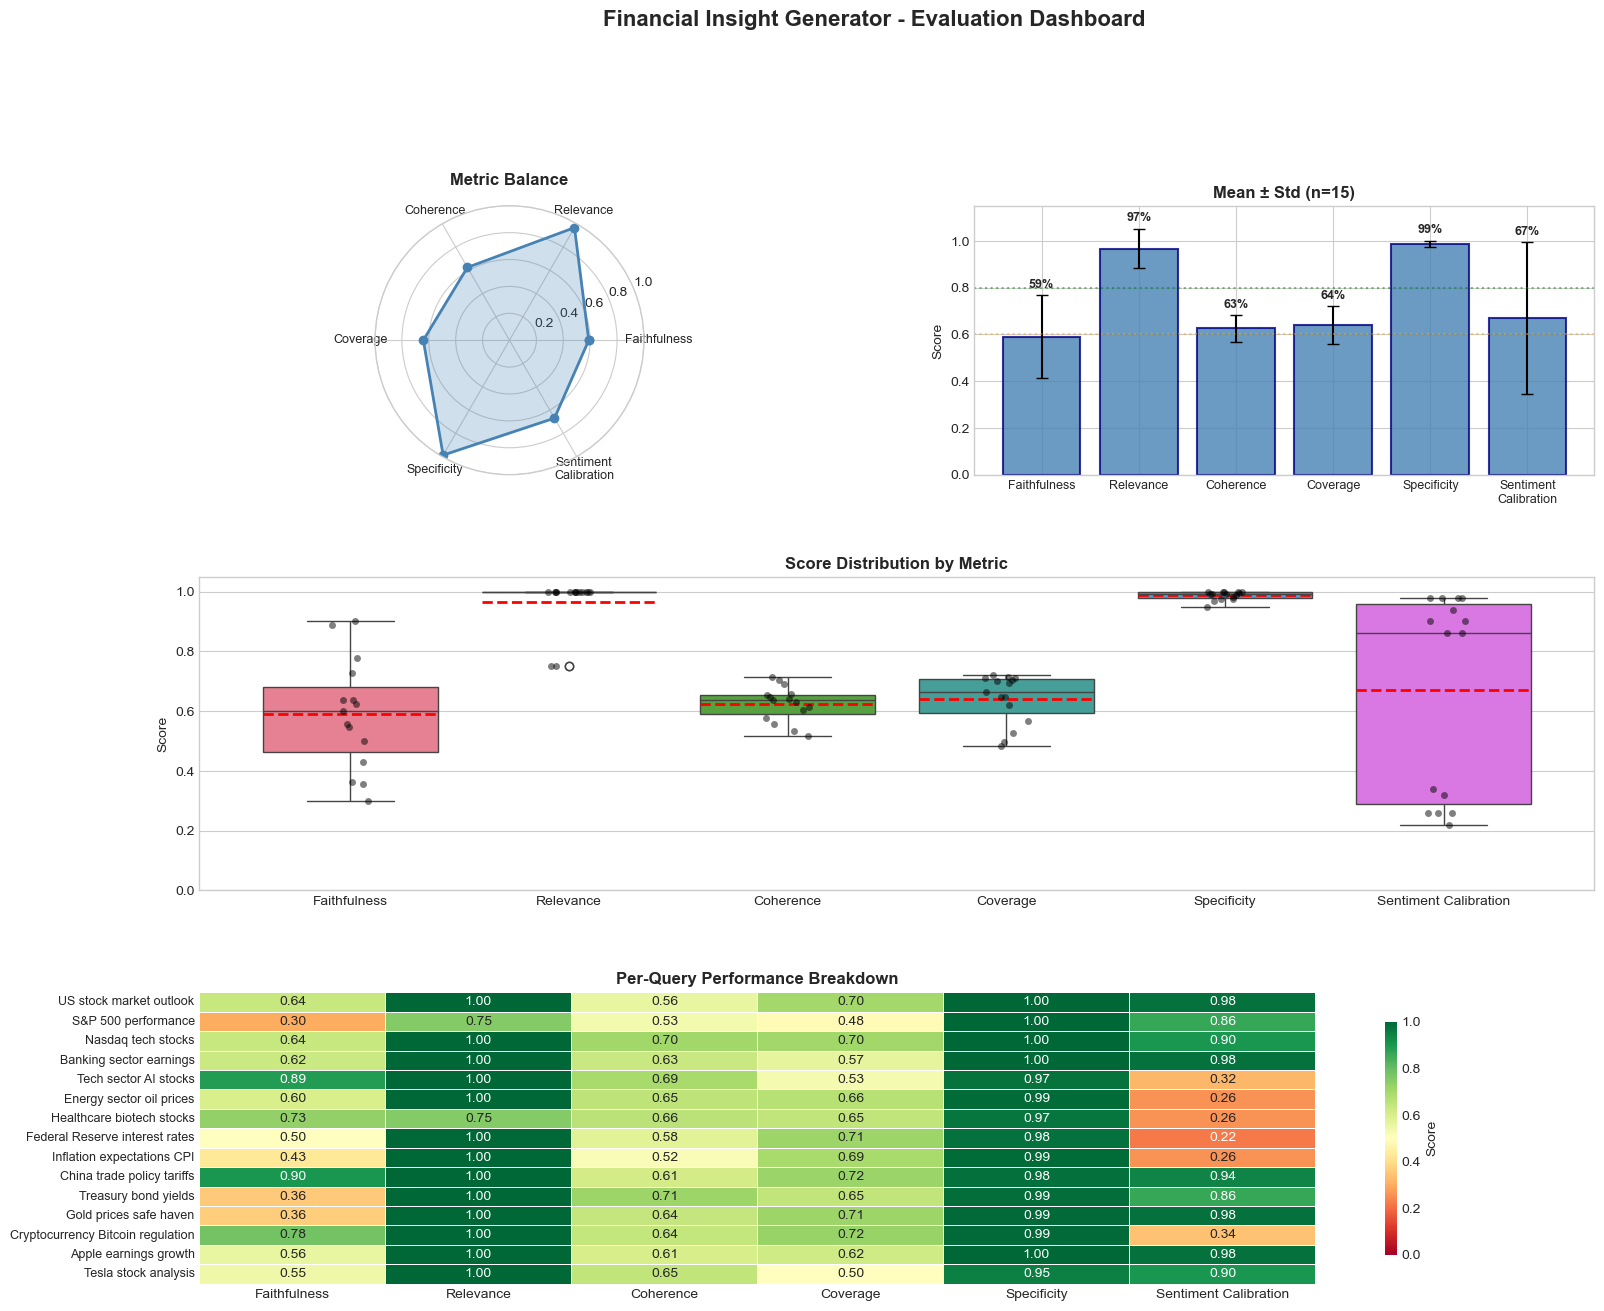


AGGREGATE STATISTICS
               Metric  Mean   Std   Min    Max
         Faithfulness 58.9% 17.7% 30.0%  90.0%
            Relevance 96.7%  8.5% 75.0% 100.0%
            Coherence 62.5%  5.7% 51.7%  71.4%
             Coverage 64.1%  8.0% 48.3%  72.0%
          Specificity 98.7%  1.4% 94.9% 100.0%
Sentiment Calibration 66.9% 32.4% 22.0%  98.0%
      Aggregate Score 73.3%  6.5% 59.3%  85.9%


In [6]:
display_evaluation_dashboard(batch_eval)

**-- With Reddit Scrapping**

In [7]:
print("=" * 60)
print("Financial Insight Generator - Batch Evaluation (With Reddit Scrapping)")
print("=" * 60)

# Initialize batch evaluator
batch_eval_r = BatchEvaluator(
    output_dir="evaluation_results_reddit",
    include_social=True 
)

# Run evaluation on all test queries
results_df_r = batch_eval_r.run_batch(TEST_QUERIES)

# Save all outputs
output_paths_r = batch_eval_r.save_all_results()

print("\n" + "=" * 60)
print("EVALUATION COMPLETE")
print("=" * 60)
print(f"\nOutputs saved to:")
for name, path in output_paths_r.items():
    print(f"  • {name}: {path}")

2026-01-16 14:43:32,915 - INFO - Initializing evaluator...
2026-01-16 14:43:32,935 - INFO - Loading embedding model: all-MiniLM-L6-v2
2026-01-16 14:43:32,938 - INFO - Use pytorch device_name: mps
2026-01-16 14:43:32,938 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Financial Insight Generator - Batch Evaluation (With Reddit Scrapping)


2026-01-16 14:43:35,145 - INFO - FinancialInsightEvaluator initialized successfully
2026-01-16 14:43:35,149 - INFO - Starting batch evaluation on 15 queries
2026-01-16 14:43:35,149 - INFO - ============================================================
Evaluating queries:   0%|          | 0/15 [00:00<?, ?it/s]2026-01-16 14:43:35,151 - INFO - 
[1/15] Processing: US stock market outlook
2026-01-16 14:43:35,152 - INFO - [US stock market outlook] Scraping news sources...
2026-01-16 14:43:44,550 - INFO - Fetched 0 RSS articles
2026-01-16 14:43:45,345 - INFO - Fetched 98 Google News articles
2026-01-16 14:43:46,222 - INFO - Fetched 0 Finnhub articles
2026-01-16 14:43:46,538 - INFO - Fetched 0 Alpha Vantage articles
2026-01-16 14:43:47,055 - INFO - Fetched 97 NewsAPI articles
2026-01-16 14:43:52,114 - INFO - Fetched 117 Reddit posts
2026-01-16 14:43:52,127 - INFO - Total articles before deduplication: 312
2026-01-16 14:43:52,155 - INFO - Total articles after deduplication: 303
2026-01-16 14:43:

                                                 title   source  quality_score
156  JPM stock today jumps even after JPMorgan earn...  NewsAPI           0.75
98   Watch this key level in the bond market for si...  NewsAPI           0.75
125  DexCom (DXCM) Releases Preliminary, Unaudited ...  NewsAPI           0.75
126  SKYX Announces $4 Million Strategic Investment...  NewsAPI           0.75
127  US stock market crashes again today – Why Dow,...  NewsAPI           0.75
128  Here’s What Supports Mondelez International’s ...  NewsAPI           0.75
129  BofA CEO Brian Moynihan ‘bullish’ on US econom...  NewsAPI           0.75
130       Earnings roundup: Infosys, Licious and Groww  NewsAPI           0.75
131  Ned Davis Distills Political Angst Into ‘Big M...  NewsAPI           0.75
132  Triple Flag Delivers Record GEOs for the Ninth...  NewsAPI           0.75
source
NewsAPI                      97
Reddit r/stocks              29
Reddit r/investing           28
Reddit r/fatFIRE            

2026-01-16 14:43:54,145 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:43:56,185 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:43:58,920 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:43:58,964 - INFO - [US stock market outlook] Evaluating output...
2026-01-16 14:43:58,964 - INFO - ============================================================
2026-01-16 14:43:58,965 - INFO - Starting comprehensive evaluation
2026-01-16 14:43:58,965 - INFO - ============================================================
2026-01-16 14:43:58,965 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:43:59,879 - INFO - Faithfulness: 2/9 claims supported (score: 0.222)
2026-01-16 14:43:59,881 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:44:03,304 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:44:03,309 - INFO - Relevance: 5.0/5 (semantic sim: 0.551)
2026-01-16 14:44:03,310 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:44:08,168 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:44:08,182 - INFO - Coherence: 4.0/5 (internal: 0.557)
2026-01-16 14:44:08,183 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:44:08,319 - INFO - Coverage: 7/20 terms (score: 0.453)
2026-01-16 14:44:08,320 - INFO - Evaluating specificity...
2026-01-16 14:44:08,321 - INFO - Specificity: 11 entities, 5 numerics, 2 vague phrases
2026-01-16 14:44:08,321 - INFO - Evaluating sentiment calibration...
2026-01-16 14:44:09,003 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:44:09,008 - INFO - Sentiment calibration: stated=positive, detected=neutral
2026-01-16 14:44:09,009 - INFO - ============================================================
2026-01-16 14:44:09,010 - INFO - Evaluation complete. Aggregate score: 0.578
2026-01-16 14:44:09,011 - INFO - ============================================================
Evaluating queries:   7%|▋         | 1/15 [00:33<07:54, 33.87s/it]2026-01-16 14:44:09,020 - INFO - 
[2/15] Processing: S&P 500 performance
2026-01-16 14:44:09,020 - INFO - [S&P 500 performance] Scraping news sources...
2026-01-16 14:44:19,589 - INF

                                                 title   source  quality_score
125              Show HN: Dgdoc – Go Office Templating  NewsAPI           0.75
157   Here’s What Lifted Johnson & Johnson (JNJ) in Q4  NewsAPI           0.75
155  Ahead of Market: 10 things that will decide st...  NewsAPI           0.75
154  Voting Is Now Open! Pick The 15 Finalists To C...  NewsAPI           0.75
153                          Where REITs Stand in 2026  NewsAPI           0.75
152  Crypto’s 2026 comeback hinges on three outcome...  NewsAPI           0.75
100  MrBeast platform gets $200 million investment ...  NewsAPI           0.75
101  SoFi Announces Monthly Distributions on $THTA ...  NewsAPI           0.75
102  Lowest-Dose Radiography Meets Next-Level Imagi...  NewsAPI           0.75
103  IDEXX Advances the Future of Veterinary Cancer...  NewsAPI           0.75
source
NewsAPI                                                 95
Reddit r/stocks                                         17
Reddit

2026-01-16 14:44:27,355 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:44:28,957 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:44:30,774 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:44:30,809 - INFO - [S&P 500 performance] Evaluating output...
2026-01-16 14:44:30,810 - INFO - ============================================================
2026-01-16 14:44:30,810 - INFO - Starting comprehensive evaluation
2026-01-16 14:44:30,810 - INFO - ============================================================
2026-01-16 14:44:30,810 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:44:31,445 - INFO - Faithfulness: 6/7 claims supported (score: 0.857)
2026-01-16 14:44:31,446 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:44:34,479 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:44:34,494 - INFO - Relevance: 5.0/5 (semantic sim: 0.703)
2026-01-16 14:44:34,495 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:44:39,000 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:44:39,005 - INFO - Coherence: 4.0/5 (internal: 0.398)
2026-01-16 14:44:39,006 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:44:39,093 - INFO - Coverage: 11/20 terms (score: 0.603)
2026-01-16 14:44:39,093 - INFO - Evaluating specificity...
2026-01-16 14:44:39,094 - INFO - Specificity: 13 entities, 13 numerics, 2 vague phrases
2026-01-16 14:44:39,094 - INFO - Evaluating sentiment calibration...
2026-01-16 14:44:39,735 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:44:39,739 - INFO - Sentiment calibration: stated=positive, detected=neutral
2026-01-16 14:44:39,739 - INFO - ============================================================
2026-01-16 14:44:39,740 - INFO - Evaluation complete. Aggregate score: 0.763
2026-01-16 14:44:39,741 - INFO - ============================================================
Evaluating queries:  13%|█▎        | 2/15 [01:04<06:56, 32.02s/it]2026-01-16 14:44:39,747 - INFO - 
[3/15] Processing: Nasdaq tech stocks
2026-01-16 14:44:39,747 - INFO - [Nasdaq tech stocks] Scraping news sources...
2026-01-16 14:44:49,384 - INF

                                                 title   source  quality_score
121  Bitcoin price (BTC USD) hits 2-month high afte...  NewsAPI           0.75
145  Mike Novogratz Tells Scaramucci Crypto Treasur...  NewsAPI           0.75
151  Stock market today: Dow, S&P 500, Nasdaq futur...  NewsAPI           0.75
150  Stock market today: Dow, S&P 500, Nasdaq futur...  NewsAPI           0.75
149  Stock market today: S&P 500, Dow, Nasdaq mixed...  NewsAPI           0.75
148  Stock Market Live Updates 13 January 2026: Sto...  NewsAPI           0.75
147  S&P 500, Dow hit closing record highs; Walmart...  NewsAPI           0.75
146  Sensex falls over 200 points led by FMCG, IT s...  NewsAPI           0.75
144  Here Are Tuesday’s Top Wall Street Analyst Res...  NewsAPI           0.75
153  Litecoin price outlook: is $80 next as BTC rec...  NewsAPI           0.75
source
NewsAPI                            88
Nasdaq                             37
Reddit r/stocks                    28
Reddit r/i

2026-01-16 14:44:56,302 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:44:57,880 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:44:59,883 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:44:59,908 - INFO - [Nasdaq tech stocks] Evaluating output...
2026-01-16 14:44:59,908 - INFO - ============================================================
2026-01-16 14:44:59,909 - INFO - Starting comprehensive evaluation
2026-01-16 14:44:59,909 - INFO - ============================================================
2026-01-16 14:44:59,909 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:45:00,458 - INFO - Faithfulness: 4/11 claims supported (score: 0.364)
2026-01-16 14:45:00,459 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:45:03,364 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:45:03,375 - INFO - Relevance: 5.0/5 (semantic sim: 0.621)
2026-01-16 14:45:03,376 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:45:12,679 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:45:12,687 - INFO - Coherence: 4.0/5 (internal: 0.531)
2026-01-16 14:45:12,688 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:45:12,863 - INFO - Coverage: 9/20 terms (score: 0.556)
2026-01-16 14:45:12,863 - INFO - Evaluating specificity...
2026-01-16 14:45:12,864 - INFO - Specificity: 16 entities, 8 numerics, 2 vague phrases
2026-01-16 14:45:12,864 - INFO - Evaluating sentiment calibration...
2026-01-16 14:45:13,559 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:45:13,614 - INFO - Sentiment calibration: stated=positive, detected=neutral
2026-01-16 14:45:13,615 - INFO - ============================================================
2026-01-16 14:45:13,616 - INFO - Evaluation complete. Aggregate score: 0.634
2026-01-16 14:45:13,616 - INFO - ============================================================
Evaluating queries:  20%|██        | 3/15 [01:38<06:34, 32.87s/it]2026-01-16 14:45:13,625 - INFO - 
[4/15] Processing: Banking sector earnings
2026-01-16 14:45:13,625 - INFO - [Banking sector earnings] Scraping news sources...
2026-01-16 14:45:22,9

                                                 title   source  quality_score
106  Jim Cramer reviews earnings from JPMorgan, Wel...  NewsAPI           0.75
112  US stock market crashes again today – Why Dow,...  NewsAPI           0.75
131  The fiscal tightrope: Why India’s goldilocks e...  NewsAPI           0.75
132  Mint Explainer | Inside the Shriram–MUFG deal:...  NewsAPI           0.75
133  Earnings better than expected, but IT sector s...  NewsAPI           0.75
134  JPMorgan Chase is set to report fourth-quarter...  NewsAPI           0.75
135  TCS shares in focus as Q3 net profit drops 14%...  NewsAPI           0.75
136  HCL Tech shares in focus after Q3 net profit d...  NewsAPI           0.75
137  Sensex, Nifty seen opening firm amid earnings ...  NewsAPI           0.75
138  Stock market today: S&P 500, Dow, Nasdaq mixed...  NewsAPI           0.75
source
NewsAPI                                                95
Yahoo Finance                                          18
Financia

2026-01-16 14:45:30,229 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:45:32,130 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:45:34,710 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:45:34,731 - INFO - [Banking sector earnings] Evaluating output...
2026-01-16 14:45:34,732 - INFO - ============================================================
2026-01-16 14:45:34,732 - INFO - Starting comprehensive evaluation
2026-01-16 14:45:34,732 - INFO - ============================================================
2026-01-16 14:45:34,732 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:45:35,375 - INFO - Faithfulness: 3/12 claims supported (score: 0.250)
2026-01-16 14:45:35,376 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:45:38,085 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:45:38,089 - INFO - Relevance: 5.0/5 (semantic sim: 0.718)
2026-01-16 14:45:38,089 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:45:42,444 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 502 Bad Gateway"
2026-01-16 14:45:42,451 - INFO - Retrying request to /chat/completions in 0.377084 seconds
2026-01-16 14:45:46,288 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:45:46,293 - INFO - Coherence: 4.0/5 (internal: 0.445)
2026-01-16 14:45:46,294 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:45:46,456 - INFO - Coverage: 8/20 terms (score: 0.556)
2026-01-16 14:45:46,457 - INFO - Evaluating specificity...
2026-01-16 14:45:46,457 - INFO - Specificity: 10 entities, 7 numerics, 5 vague phrases
2026-01-16 14:45:46,458 - INFO - Evaluating sentiment calibration...
2026-01-16 14:45:47,146 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:45:47,154 - INFO - Sentiment calibration: stated=positive, detected=neutral
2026-01-16 14:45:47,155 - INFO - ============================================================
2026-01-16 14:45:47,156 - INFO - Evaluation complete. Aggregate score: 0.596
2026-01-16 14:45:47,156 - INFO - ============================================================
Evaluating queries:  27%|██▋       | 4/15 [02:12<06:04, 33.14s/it]2026-01-16 14:45:47,171 - INFO - 
[5/15] Processing: Tech sector AI stocks
2026-01-16 14:45:47,171 - INFO - [Tech sector AI stocks] Scraping news sources...
2026-01-16 14:46:13,420 -

                                                 title   source  quality_score
136  Power Hungry: Inside Meta’s Huge Investment in...  NewsAPI           0.75
119  Earnings Season to Put Wall Street’s Rotation ...  NewsAPI           0.75
111  CNBC Daily Open: Worries over Iran and Fed ind...  NewsAPI           0.75
112  Trump's Crypto Czar Should Resign If Crypto Bi...  NewsAPI           0.75
113  Stock Market Highlights 14 Jan 2026: Sensex, N...  NewsAPI           0.75
114  AI Could Spell Trouble for Software. These Exp...  NewsAPI           0.75
115  Ignore the Apple Noise and Consider Buying Qua...  NewsAPI           0.75
116  Small Names, Big Impact: The Stocks Behind NVI...  NewsAPI           0.75
117  Google Co-Founder Larry Page Is Reportedly Exi...  NewsAPI           0.75
118  US stock market crashes again today: Why Dow, ...  NewsAPI           0.75
source
NewsAPI                      98
Reddit r/stocks              30
Reddit r/investing           18
The Motley Fool             

2026-01-16 14:46:22,026 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:46:23,798 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:46:26,153 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:46:26,185 - INFO - [Tech sector AI stocks] Evaluating output...
2026-01-16 14:46:26,186 - INFO - ============================================================
2026-01-16 14:46:26,186 - INFO - Starting comprehensive evaluation
2026-01-16 14:46:26,186 - INFO - ============================================================
2026-01-16 14:46:26,186 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:46:27,019 - INFO - Faithfulness: 8/10 claims supported (score: 0.800)
2026-01-16 14:46:27,019 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:46:30,007 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:46:30,016 - INFO - Relevance: 4.0/5 (semantic sim: 0.619)
2026-01-16 14:46:30,017 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:46:33,405 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:46:33,412 - INFO - Coherence: 4.0/5 (internal: 0.246)
2026-01-16 14:46:33,413 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:46:33,547 - INFO - Coverage: 4/20 terms (score: 0.458)
2026-01-16 14:46:33,548 - INFO - Evaluating specificity...
2026-01-16 14:46:33,548 - INFO - Specificity: 11 entities, 6 numerics, 2 vague phrases
2026-01-16 14:46:33,548 - INFO - Evaluating sentiment calibration...
2026-01-16 14:46:34,218 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:46:34,223 - INFO - Sentiment calibration: stated=positive, detected=positive
2026-01-16 14:46:34,224 - INFO - ============================================================
2026-01-16 14:46:34,224 - INFO - Evaluation complete. Aggregate score: 0.734
2026-01-16 14:46:34,225 - INFO - ============================================================
Evaluating queries:  33%|███▎      | 5/15 [02:59<06:21, 38.16s/it]2026-01-16 14:46:34,232 - INFO - 
[6/15] Processing: Energy sector oil prices
2026-01-16 14:46:34,233 - INFO - [Energy sector oil prices] Scraping news sources...
2026-01-16 14:46:4

                                                 title   source  quality_score
118  US Plastic Market Poised to Grow from $195.37 ...  NewsAPI           0.75
143  US carbon pollution rose in 2025. Experts blam...  NewsAPI           0.75
149  Michael Hudson: Weaponizing the World’s Oil Tr...  NewsAPI           0.75
148  Stocks Little Changed Despite a Fed-Friendly U...  NewsAPI           0.75
147     A weak rupee is not a strategy, it is a signal  NewsAPI           0.75
146  Venezuela’s oil is secondary to the dollar pro...  NewsAPI           0.75
145  Aviation Fuel Market size worth $ 933.16 Billi...  NewsAPI           0.75
144  US stock market crashes again today: Why Dow, ...  NewsAPI           0.75
142  The 6 Ways Trump Tried To Control the Economy ...  NewsAPI           0.75
136  Venezuelan Oil and the Limits of U.S. Refining...  NewsAPI           0.75
source
NewsAPI                                  93
Reuters                                  29
Reddit r/stocks                     

2026-01-16 14:46:52,639 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:46:53,745 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:46:55,533 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:46:55,571 - INFO - [Energy sector oil prices] Evaluating output...
2026-01-16 14:46:55,572 - INFO - ============================================================
2026-01-16 14:46:55,572 - INFO - Starting comprehensive evaluation
2026-01-16 14:46:55,572 - INFO - ============================================================
2026-01-16 14:46:55,572 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:46:56,091 - INFO - Faithfulness: 3/12 claims supported (score: 0.250)
2026-01-16 14:46:56,092 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:46:59,292 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:46:59,300 - INFO - Relevance: 5.0/5 (semantic sim: 0.564)
2026-01-16 14:46:59,300 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:47:03,578 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:47:03,583 - INFO - Coherence: 4.0/5 (internal: 0.628)
2026-01-16 14:47:03,583 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:47:03,685 - INFO - Coverage: 11/20 terms (score: 0.624)
2026-01-16 14:47:03,686 - INFO - Evaluating specificity...
2026-01-16 14:47:03,686 - INFO - Specificity: 11 entities, 5 numerics, 4 vague phrases
2026-01-16 14:47:03,687 - INFO - Evaluating sentiment calibration...
2026-01-16 14:47:04,562 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:47:04,567 - INFO - Sentiment calibration: stated=positive, detected=negative
2026-01-16 14:47:04,567 - INFO - ============================================================
2026-01-16 14:47:04,568 - INFO - Evaluation complete. Aggregate score: 0.615
2026-01-16 14:47:04,569 - INFO - ============================================================
Evaluating queries:  40%|████      | 6/15 [03:29<05:19, 35.50s/it]2026-01-16 14:47:04,577 - INFO - 
[7/15] Processing: Healthcare biotech stocks
2026-01-16 14:47:04,577 - INFO - [Healthcare biotech stocks] Scraping news sources...
2026-01-16 14:4

                                                 title   source  quality_score
104  Big Pharma race to snap up biotech assets as $...  NewsAPI           0.75
109  Cardinal Health (CAH) Repositions for Growth w...  NewsAPI           0.75
117  Bloom Energy (BE): Mixed Analyst Outlook Amid ...  NewsAPI           0.75
116  ETFs, mutual funds or direct stocks? Choosing ...  NewsAPI           0.75
115  Raymond James Sees an Attractive Setup in Thes...  NewsAPI           0.75
113  Chinese Stocks on Track for Best Year Since 20...  NewsAPI           0.75
112  ASX ends 'stressful' year with value of gold a...  NewsAPI           0.75
111  Stock Market Live Updates 31 Dec 2025: Indian ...  NewsAPI           0.75
110  Investors quietly pile into a group of stocks ...  NewsAPI           0.75
108  Artisan Mid Cap Value Fund Increased its Stake...  NewsAPI           0.75
source
NewsAPI                            29
The Motley Fool                    15
Finimize                            7
Barron's  

2026-01-16 14:47:22,235 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:47:23,399 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:47:26,347 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:47:26,367 - INFO - [Healthcare biotech stocks] Evaluating output...
2026-01-16 14:47:26,367 - INFO - ============================================================
2026-01-16 14:47:26,368 - INFO - Starting comprehensive evaluation
2026-01-16 14:47:26,368 - INFO - ============================================================
2026-01-16 14:47:26,368 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:47:27,156 - INFO - Faithfulness: 5/9 claims supported (score: 0.556)
2026-01-16 14:47:27,157 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:47:29,545 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:47:29,552 - INFO - Relevance: 4.0/5 (semantic sim: 0.712)
2026-01-16 14:47:29,552 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:47:33,843 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:47:33,853 - INFO - Coherence: 3.0/5 (internal: 0.224)
2026-01-16 14:47:33,855 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:47:33,980 - INFO - Coverage: 13/20 terms (score: 0.674)
2026-01-16 14:47:33,980 - INFO - Evaluating specificity...
2026-01-16 14:47:33,981 - INFO - Specificity: 16 entities, 5 numerics, 1 vague phrases
2026-01-16 14:47:33,981 - INFO - Evaluating sentiment calibration...
2026-01-16 14:47:34,610 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:47:34,620 - INFO - Sentiment calibration: stated=negative, detected=neutral
2026-01-16 14:47:34,621 - INFO - ============================================================
2026-01-16 14:47:34,622 - INFO - Evaluation complete. Aggregate score: 0.608
2026-01-16 14:47:34,622 - INFO - ============================================================
Evaluating queries:  47%|████▋     | 7/15 [03:59<04:29, 33.72s/it]2026-01-16 14:47:34,634 - INFO - 
[8/15] Processing: Federal Reserve interest rates
2026-01-16 14:47:34,634 - INFO - [Federal Reserve interest rates] Scraping news sources...
2026-0

                                                 title   source  quality_score
129  Fed officials stress independence amid Trump a...  NewsAPI           0.75
108  US jobless claims drop to 198,000, beating for...  NewsAPI           0.75
101  Trump says he has no plans to remove Powell de...  NewsAPI           0.75
102  When Is Jerome Powell’s Term Up? Find Out When...  NewsAPI           0.75
103  Mortgage Rates Today, Thursday, January 15: St...  NewsAPI           0.75
104  Forget Trump vs Powell — Ted Cruz wants to abo...  NewsAPI           0.75
105  GOP senator pushes Trump's 10% credit card rat...  NewsAPI           0.75
106  2025 Household Credit Card Debt Study: 49% Say...  NewsAPI           0.75
107  Fed's Goolsbee says inflation could come 'roar...  NewsAPI           0.75
109  Just 198,000 Americans filed jobless claims la...  NewsAPI           0.75
source
NewsAPI                     96
Reddit r/stocks             19
Reddit r/investing          14
Reddit r/fatFIRE             7


2026-01-16 14:47:57,491 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:47:59,273 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:48:01,817 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:48:01,848 - INFO - [Federal Reserve interest rates] Evaluating output...
2026-01-16 14:48:01,848 - INFO - ============================================================
2026-01-16 14:48:01,849 - INFO - Starting comprehensive evaluation
2026-01-16 14:48:01,849 - INFO - ============================================================
2026-01-16 14:48:01,849 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:48:02,455 - INFO - Faithfulness: 5/8 claims supported (score: 0.625)
2026-01-16 14:48:02,457 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:48:06,414 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:48:06,441 - INFO - Relevance: 5.0/5 (semantic sim: 0.608)
2026-01-16 14:48:06,443 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:48:12,461 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:48:12,479 - INFO - Coherence: 4.0/5 (internal: 0.593)
2026-01-16 14:48:12,480 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:48:12,584 - INFO - Coverage: 10/20 terms (score: 0.641)
2026-01-16 14:48:12,585 - INFO - Evaluating specificity...
2026-01-16 14:48:12,585 - INFO - Specificity: 19 entities, 7 numerics, 1 vague phrases
2026-01-16 14:48:12,586 - INFO - Evaluating sentiment calibration...
2026-01-16 14:48:13,597 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:48:13,601 - INFO - Sentiment calibration: stated=positive, detected=positive
2026-01-16 14:48:13,602 - INFO - ============================================================
2026-01-16 14:48:13,602 - INFO - Evaluation complete. Aggregate score: 0.788
2026-01-16 14:48:13,603 - INFO - ============================================================
Evaluating queries:  53%|█████▎    | 8/15 [04:38<04:07, 35.39s/it]2026-01-16 14:48:13,609 - INFO - 
[9/15] Processing: Inflation expectations CPI
2026-01-16 14:48:13,609 - INFO - [Inflation expectations CPI] Scraping news sources...
2026-01-16 14

                                                 title   source  quality_score
108  Stock Index Futures Slip With Focus on U.S. Re...  NewsAPI           0.75
130  Yen tumbles on Japan spending fears, dollar br...  NewsAPI           0.75
132  Bitcoin attempts $92K breakout as stocks hit n...  NewsAPI           0.75
133  Breaking: Positive Inflation Report Delivers E...  NewsAPI           0.75
134  Stocks Little Changed Despite a Fed-Friendly U...  NewsAPI           0.75
135         Why Is Crypto Up Today? – January 13, 2026  NewsAPI           0.75
136  December core consumer prices rose at a 2.6% a...  NewsAPI           0.75
137  Core Consumer Prices Rise Less Than Expected, ...  NewsAPI           0.75
138  Annual inflation remains 2.7% in December, fin...  NewsAPI           0.75
139                 US inflation rose 2.7% in December  NewsAPI           0.75
source
NewsAPI                                                  97
CNBC                                                      8
Yaho

2026-01-16 14:48:28,715 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:48:30,001 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:48:31,407 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:48:31,426 - INFO - [Inflation expectations CPI] Evaluating output...
2026-01-16 14:48:31,427 - INFO - ============================================================
2026-01-16 14:48:31,427 - INFO - Starting comprehensive evaluation
2026-01-16 14:48:31,427 - INFO - ============================================================
2026-01-16 14:48:31,427 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:48:32,021 - INFO - Faithfulness: 8/12 claims supported (score: 0.667)
2026-01-16 14:48:32,021 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:48:34,712 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:48:34,717 - INFO - Relevance: 5.0/5 (semantic sim: 0.606)
2026-01-16 14:48:34,718 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:48:39,003 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:48:39,014 - INFO - Coherence: 4.0/5 (internal: 0.159)
2026-01-16 14:48:39,015 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:48:39,094 - INFO - Coverage: 14/20 terms (score: 0.719)
2026-01-16 14:48:39,094 - INFO - Evaluating specificity...
2026-01-16 14:48:39,095 - INFO - Specificity: 21 entities, 9 numerics, 3 vague phrases
2026-01-16 14:48:39,095 - INFO - Evaluating sentiment calibration...
2026-01-16 14:48:40,015 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:48:40,022 - INFO - Sentiment calibration: stated=positive, detected=neutral
2026-01-16 14:48:40,023 - INFO - ============================================================
2026-01-16 14:48:40,024 - INFO - Evaluation complete. Aggregate score: 0.710
2026-01-16 14:48:40,024 - INFO - ============================================================
Evaluating queries:  60%|██████    | 9/15 [05:04<03:15, 32.59s/it]2026-01-16 14:48:40,031 - INFO - 
[10/15] Processing: China trade policy tariffs
2026-01-16 14:48:40,031 - INFO - [China trade policy tariffs] Scraping news sources...
2026-01-16 14

                                                 title   source  quality_score
112  Forget tariff wars: The EU and Mercosur build ...  NewsAPI           0.75
146  Opinion: Ottawa’s tariffs protect Ontario and ...  NewsAPI           0.75
133  Once an Economic Giant, Japan Now Tests a New ...  NewsAPI           0.75
134  The World’s Two Largest Economies Should Slow ...  NewsAPI           0.75
135  China Fumes at Trump’s Iran Tariffs After Losi...  NewsAPI           0.75
136  China invites Canada to closer relationship as...  NewsAPI           0.75
137  Why the mullahs’ regime is still holding on de...  NewsAPI           0.75
138  Bitcoin ignored Trump’s latest 25% tariff thre...  NewsAPI           0.75
139  Canada’s Carney Lands in Beijing as China Urge...  NewsAPI           0.75
140  Canadian PM Mark Carney arrives in Beijing for...  NewsAPI           0.75
source
NewsAPI                                                91
Reddit r/stocks                                        16
Reddit r

2026-01-16 14:49:12,164 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:49:13,955 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:49:16,098 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:49:16,117 - INFO - [China trade policy tariffs] Evaluating output...
2026-01-16 14:49:16,117 - INFO - ============================================================
2026-01-16 14:49:16,118 - INFO - Starting comprehensive evaluation
2026-01-16 14:49:16,119 - INFO - ============================================================
2026-01-16 14:49:16,119 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:49:16,693 - INFO - Faithfulness: 8/8 claims supported (score: 1.000)
2026-01-16 14:49:16,694 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:49:19,759 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:49:19,766 - INFO - Relevance: 5.0/5 (semantic sim: 0.629)
2026-01-16 14:49:19,766 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:49:24,702 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:49:24,715 - INFO - Coherence: 4.0/5 (internal: 0.478)
2026-01-16 14:49:24,716 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:49:24,810 - INFO - Coverage: 9/20 terms (score: 0.566)
2026-01-16 14:49:24,810 - INFO - Evaluating specificity...
2026-01-16 14:49:24,811 - INFO - Specificity: 12 entities, 5 numerics, 1 vague phrases
2026-01-16 14:49:24,811 - INFO - Evaluating sentiment calibration...
2026-01-16 14:49:25,541 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:49:25,544 - INFO - Sentiment calibration: stated=negative, detected=negative
2026-01-16 14:49:25,545 - INFO - ============================================================
2026-01-16 14:49:25,546 - INFO - Evaluation complete. Aggregate score: 0.868
2026-01-16 14:49:25,547 - INFO - ============================================================
Evaluating queries:  67%|██████▋   | 10/15 [05:50<03:02, 36.58s/it]2026-01-16 14:49:25,555 - INFO - 
[11/15] Processing: Treasury bond yields
2026-01-16 14:49:25,555 - INFO - [Treasury bond yields] Scraping news sources...
2026-01-16 14:49:32,726 

                                                 title   source  quality_score
103  Asian shares are mostly lower and oil sinks $2...  NewsAPI           0.75
128  India bonds fall after Bloomberg index entry s...  NewsAPI           0.75
130  Why fixed-income investors should shift focus ...  NewsAPI           0.75
131  Takaichi Trade Roars Back as Japan Snap Electi...  NewsAPI           0.75
132   Asian shares rise on valuations, dollar declines  NewsAPI           0.75
133  The Market Met Jerome Powell’s Warning With De...  NewsAPI           0.75
134  What Justice Department investigation of Fed c...  NewsAPI           0.75
135  Bitcoin just broke its classic macro correlati...  NewsAPI           0.75
136  Why the Federal Reserve's independence from th...  NewsAPI           0.75
137  Former officials say DOJ probe threatens Fed i...  NewsAPI           0.75
source
NewsAPI                      90
CNBC                         35
Reuters                       7
Tradeweb                    

2026-01-16 14:49:41,617 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:49:42,401 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:49:44,422 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:49:44,445 - INFO - [Treasury bond yields] Evaluating output...
2026-01-16 14:49:44,445 - INFO - ============================================================
2026-01-16 14:49:44,445 - INFO - Starting comprehensive evaluation
2026-01-16 14:49:44,446 - INFO - ============================================================
2026-01-16 14:49:44,446 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:49:45,132 - INFO - Faithfulness: 6/15 claims supported (score: 0.400)
2026-01-16 14:49:45,133 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:49:47,427 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:49:47,434 - INFO - Relevance: 4.0/5 (semantic sim: 0.574)
2026-01-16 14:49:47,435 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:49:52,956 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:49:52,961 - INFO - Coherence: 4.0/5 (internal: 0.615)
2026-01-16 14:49:52,962 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:49:53,043 - INFO - Coverage: 12/20 terms (score: 0.716)
2026-01-16 14:49:53,044 - INFO - Evaluating specificity...
2026-01-16 14:49:53,044 - INFO - Specificity: 21 entities, 10 numerics, 2 vague phrases
2026-01-16 14:49:53,044 - INFO - Evaluating sentiment calibration...
2026-01-16 14:49:53,784 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:49:53,788 - INFO - Sentiment calibration: stated=negative, detected=negative
2026-01-16 14:49:53,789 - INFO - ============================================================
2026-01-16 14:49:53,789 - INFO - Evaluation complete. Aggregate score: 0.680
2026-01-16 14:49:53,790 - INFO - ============================================================
Evaluating queries:  73%|███████▎  | 11/15 [06:18<02:16, 34.03s/it]2026-01-16 14:49:53,797 - INFO - 
[12/15] Processing: Gold prices safe haven
2026-01-16 14:49:53,797 - INFO - [Gold prices safe haven] Scraping news sources...
2026-01-16 14:50:0

                                                 title   source  quality_score
111  Metal shares extend bull run as commodity rall...  NewsAPI           0.75
132  Gold vaults to record $4,600/oz as Trump-Powel...  NewsAPI           0.75
134  European shares gain as probe launched into US...  NewsAPI           0.75
135  US prosecutors open probe of Fed chief, escala...  NewsAPI           0.75
136  Markets shudder as White House goes to war wit...  NewsAPI           0.75
137  Wedding trousseaus to bear the brunt of gold, ...  NewsAPI           0.75
138  US prosecutors have opened an inquiry into Fed...  NewsAPI           0.75
139  Trouble ahead for US housing, warns 'Oracle of...  NewsAPI           0.75
140  US stock market crashes today: Why Dow, S&P 50...  NewsAPI           0.75
141  Factbox - How investors buy gold & what fuels ...  NewsAPI           0.75
source
NewsAPI                     89
FXStreet                    11
Reddit r/investing          10
KITCO                        7


2026-01-16 14:50:14,835 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:50:16,101 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:50:17,940 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:50:17,958 - INFO - [Gold prices safe haven] Evaluating output...
2026-01-16 14:50:17,959 - INFO - ============================================================
2026-01-16 14:50:17,959 - INFO - Starting comprehensive evaluation
2026-01-16 14:50:17,959 - INFO - ============================================================
2026-01-16 14:50:17,959 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:50:18,556 - INFO - Faithfulness: 6/11 claims supported (score: 0.545)
2026-01-16 14:50:18,557 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:50:21,768 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:50:21,779 - INFO - Relevance: 5.0/5 (semantic sim: 0.724)
2026-01-16 14:50:21,780 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:50:25,881 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:50:25,890 - INFO - Coherence: 4.0/5 (internal: 0.191)
2026-01-16 14:50:25,891 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:50:26,013 - INFO - Coverage: 15/20 terms (score: 0.802)
2026-01-16 14:50:26,013 - INFO - Evaluating specificity...
2026-01-16 14:50:26,014 - INFO - Specificity: 12 entities, 10 numerics, 0 vague phrases
2026-01-16 14:50:26,014 - INFO - Evaluating sentiment calibration...
2026-01-16 14:50:26,677 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:50:26,678 - INFO - Sentiment calibration: stated=positive, detected=positive
2026-01-16 14:50:26,678 - INFO - ============================================================
2026-01-16 14:50:26,678 - INFO - Evaluation complete. Aggregate score: 0.772
2026-01-16 14:50:26,678 - INFO - ============================================================
Evaluating queries:  80%|████████  | 12/15 [06:51<01:41, 33.68s/it]2026-01-16 14:50:26,682 - INFO - 
[13/15] Processing: Cryptocurrency Bitcoin regulation
2026-01-16 14:50:26,683 - INFO - [Cryptocurrency Bitcoin regulation] Scraping news sources

                                                 title   source  quality_score
99   Five Bitcoin narratives analysts are watching ...  NewsAPI           0.75
124  $15 Billion Pig Butchering Scam Boss Chen Zhi ...  NewsAPI           0.75
126  Unicoin Set for Crypto Exchange Debut Followin...  NewsAPI           0.75
127  I Asked ChatGPT Which Cryptocurrency Will Make...  NewsAPI           0.75
128  Exodus Movement, Inc. December 2025 Treasury U...  NewsAPI           0.75
129  Bitwise Flags Three Conditions Crypto Must Mee...  NewsAPI           0.75
130  The boldest bitcoin predictions for 2026 are i...  NewsAPI           0.75
131  Crypto reps fly to US capitol this week to add...  NewsAPI           0.75
132          The hidden tax costs of spot bitcoin ETFs  NewsAPI           0.75
133  US Crypto Firms Face Prolonged Compliance Limb...  NewsAPI           0.75
source
NewsAPI                 97
PBS                      3
Coinpedia                3
Bitcoin world            3
CoinDesk        

2026-01-16 14:50:45,335 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:50:46,544 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:50:48,843 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:50:48,862 - INFO - [Cryptocurrency Bitcoin regulation] Evaluating output...
2026-01-16 14:50:48,863 - INFO - ============================================================
2026-01-16 14:50:48,863 - INFO - Starting comprehensive evaluation
2026-01-16 14:50:48,864 - INFO - ============================================================
2026-01-16 14:50:48,865 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:50:49,363 - INFO - Faithfulness: 3/9 claims supported (score: 0.333)
2026-01-16 14:50:49,363 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:50:52,994 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:50:53,002 - INFO - Relevance: 4.0/5 (semantic sim: 0.552)
2026-01-16 14:50:53,002 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:50:56,480 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:50:56,482 - INFO - Coherence: 4.0/5 (internal: 0.477)
2026-01-16 14:50:56,483 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:50:56,630 - INFO - Coverage: 10/20 terms (score: 0.574)
2026-01-16 14:50:56,631 - INFO - Evaluating specificity...
2026-01-16 14:50:56,632 - INFO - Specificity: 13 entities, 7 numerics, 2 vague phrases
2026-01-16 14:50:56,632 - INFO - Evaluating sentiment calibration...
2026-01-16 14:50:57,280 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:50:57,291 - INFO - Sentiment calibration: stated=positive, detected=neutral
2026-01-16 14:50:57,292 - INFO - ============================================================
2026-01-16 14:50:57,293 - INFO - Evaluation complete. Aggregate score: 0.577
2026-01-16 14:50:57,295 - INFO - ============================================================
Evaluating queries:  87%|████████▋ | 13/15 [07:22<01:05, 32.75s/it]2026-01-16 14:50:57,303 - INFO - 
[14/15] Processing: Apple earnings growth
2026-01-16 14:50:57,304 - INFO - [Apple earnings growth] Scraping news sources...
2026-01-16 14:51:07,86

                                                 title   source  quality_score
114    Samsara Is Forming a Triple Bottom—Time to Buy?  NewsAPI           0.75
148  CFOs move finance AI from pilots to deployment...  NewsAPI           0.75
135  Asian benchmarks are mixed after Wall Street p...  NewsAPI           0.75
136  Stock market today: Dow, S&P 500, Nasdaq slide...  NewsAPI           0.75
137  Dow Jones crashes, S&P 500, Nasdaq slip as U.S...  NewsAPI           0.75
138  JPMorgan Signals a Strong Year Ahead: Is JPM H...  NewsAPI           0.75
139  Why Amazon’s ‘Overbought’ Signal Isn’t a Red Flag  NewsAPI           0.75
140  Ignore the Apple Noise and Consider Buying Qua...  NewsAPI           0.75
141   Why Apple Chose Google to Power the Future of AI  NewsAPI           0.75
142  Stock Market Today, Jan. 13: Surprising Inflat...  NewsAPI           0.75
source
NewsAPI                            90
Reddit r/stocks                    18
Yahoo Finance                      13
Morningsta

2026-01-16 14:51:16,031 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:51:17,586 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:51:19,178 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:51:19,202 - INFO - [Apple earnings growth] Evaluating output...
2026-01-16 14:51:19,203 - INFO - ============================================================
2026-01-16 14:51:19,203 - INFO - Starting comprehensive evaluation
2026-01-16 14:51:19,203 - INFO - ============================================================
2026-01-16 14:51:19,203 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:51:19,768 - INFO - Faithfulness: 7/10 claims supported (score: 0.700)
2026-01-16 14:51:19,768 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:51:22,630 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:51:22,639 - INFO - Relevance: 5.0/5 (semantic sim: 0.740)
2026-01-16 14:51:22,640 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:51:26,144 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:51:26,156 - INFO - Coherence: 4.0/5 (internal: 0.489)
2026-01-16 14:51:26,157 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:51:26,403 - INFO - Coverage: 14/20 terms (score: 0.728)
2026-01-16 14:51:26,404 - INFO - Evaluating specificity...
2026-01-16 14:51:26,405 - INFO - Specificity: 13 entities, 7 numerics, 1 vague phrases
2026-01-16 14:51:26,405 - INFO - Evaluating sentiment calibration...
2026-01-16 14:51:27,134 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:51:27,139 - INFO - Sentiment calibration: stated=positive, detected=positive
2026-01-16 14:51:27,140 - INFO - ============================================================
2026-01-16 14:51:27,142 - INFO - Evaluation complete. Aggregate score: 0.819
2026-01-16 14:51:27,143 - INFO - ============================================================
Evaluating queries:  93%|█████████▎| 14/15 [07:52<00:31, 31.88s/it]2026-01-16 14:51:27,153 - INFO - 
[15/15] Processing: Tesla stock analysis
2026-01-16 14:51:27,153 - INFO - [Tesla stock analysis] Scraping news sources...
2026-01-16 14:51:39,089

                                                 title   source  quality_score
110  Bank Of America's Top 3 Commodity Stock Picks ...  NewsAPI           0.75
120  AI Regulation Battle Looms in California Despi...  NewsAPI           0.75
133                              새해 (몇 명 빼고) 복 많이 받으세요  NewsAPI           0.75
134  Out of the Greenhouse and Into the Madhouse: t...  NewsAPI           0.75
135  Cathie Wood Is Selling Tesla Stock Yet Again. ...  NewsAPI           0.75
136  Tesla Breaks With Tradition as It Braces Marke...  NewsAPI           0.75
137     5 Things to Know Before the Stock Market Opens  NewsAPI           0.75
138                                   Good Cop/Bad Cop  NewsAPI           0.75
139    Tech drags U.S. stocks as silver turns volatile  NewsAPI           0.75
140  Sam Altman and Alex Karp are learning to hate ...  NewsAPI           0.75
source
NewsAPI                        81
Barron's                       21
Reddit r/stocks                20
Yahoo Finance         

2026-01-16 14:51:47,022 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:51:48,506 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 14:51:50,221 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:51:50,247 - INFO - [Tesla stock analysis] Evaluating output...
2026-01-16 14:51:50,247 - INFO - ============================================================
2026-01-16 14:51:50,248 - INFO - Starting comprehensive evaluation
2026-01-16 14:51:50,248 - INFO - ============================================================
2026-01-16 14:51:50,248 - INFO - Evaluating faithfulness...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:51:50,959 - INFO - Faithfulness: 6/8 claims supported (score: 0.750)
2026-01-16 14:51:50,959 - INFO - Evaluating relevance...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:51:54,082 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:51:54,089 - INFO - Relevance: 5.0/5 (semantic sim: 0.574)
2026-01-16 14:51:54,090 - INFO - Evaluating coherence...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:51:58,262 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:51:58,269 - INFO - Coherence: 4.0/5 (internal: 0.601)
2026-01-16 14:51:58,270 - INFO - Evaluating coverage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 14:51:58,459 - INFO - Coverage: 7/20 terms (score: 0.502)
2026-01-16 14:51:58,459 - INFO - Evaluating specificity...
2026-01-16 14:51:58,460 - INFO - Specificity: 14 entities, 6 numerics, 3 vague phrases
2026-01-16 14:51:58,460 - INFO - Evaluating sentiment calibration...
2026-01-16 14:51:58,994 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 14:51:58,998 - INFO - Sentiment calibration: stated=positive, detected=neutral
2026-01-16 14:51:58,999 - INFO - ============================================================
2026-01-16 14:51:59,000 - INFO - Evaluation complete. Aggregate score: 0.731
2026-01-16 14:51:59,001 - INFO - ============================================================
Evaluating queries: 100%|██████████| 15/15 [08:23<00:00, 33.59s/it]
2026-01-16 14:51:59,008 - INFO - ============================================================
2026-01-16 14:51:59,008 - INFO - Batch evaluation complete!
2026-01-16 14:51:59,016 - 


EVALUATION COMPLETE

Outputs saved to:
  • results_json: evaluation_results_reddit/batch_results.json
  • summary_csv: evaluation_results_reddit/batch_summary.csv
  • statistics: evaluation_results_reddit/aggregate_statistics.json


/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_45711/2850325694.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='Metric', y='Score', ax=ax3, palette='husl')
/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_45711/2850325694.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


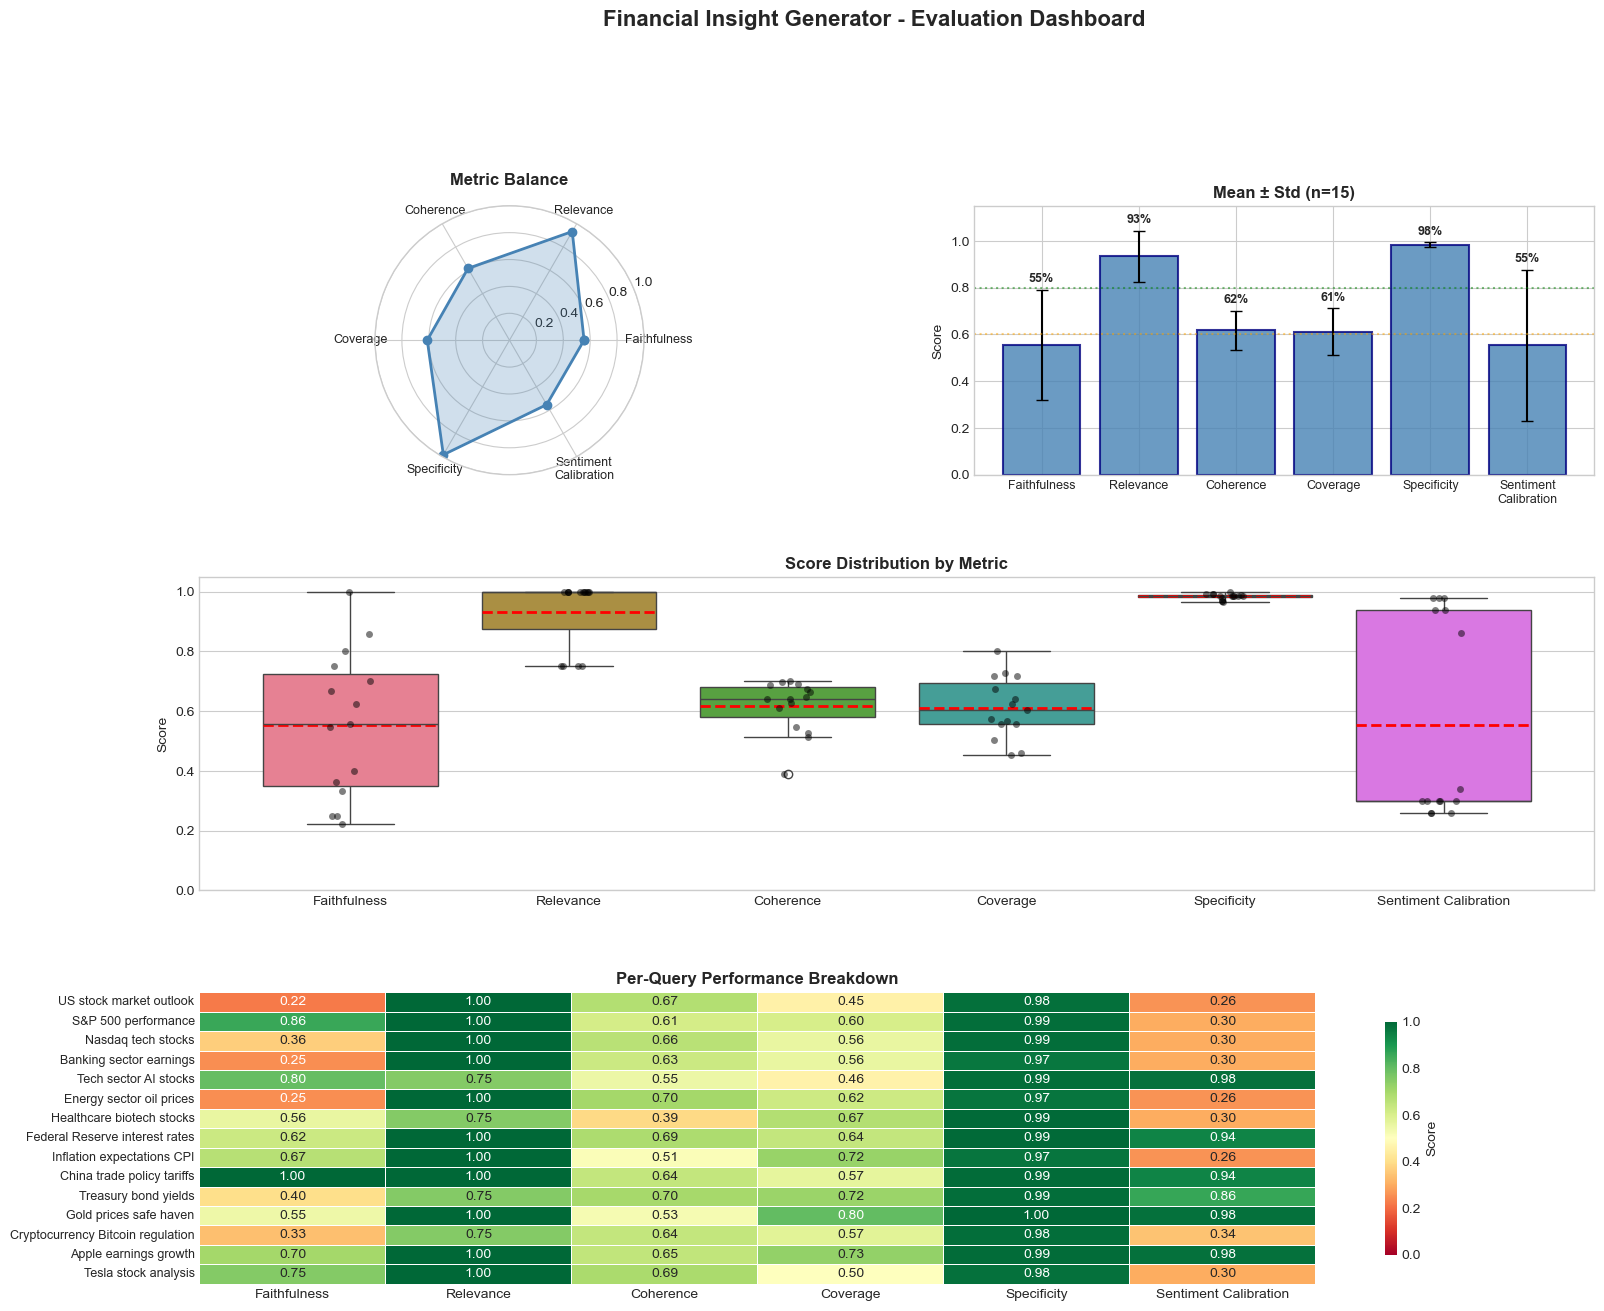


AGGREGATE STATISTICS
               Metric  Mean   Std   Min    Max
         Faithfulness 55.5% 23.6% 22.2% 100.0%
            Relevance 93.3% 11.1% 75.0% 100.0%
            Coherence 61.7%  8.4% 39.0%  70.1%
             Coverage 61.2%  9.9% 45.3%  80.2%
          Specificity 98.4%  0.9% 96.6% 100.0%
Sentiment Calibration 55.3% 32.3% 26.0%  98.0%
      Aggregate Score 69.8%  9.0% 57.7%  86.8%


In [8]:
display_evaluation_dashboard(batch_eval_r)